# Bước 0 — Chuẩn bị & kiểm tra file

In [1]:
import torch
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

In [2]:
# ==== CELL: Locate all training files (accept .jsonl or .jsonl.gz) ====
from pathlib import Path

DS = Path("/kaggle/input/dataset-phishing")   # đổi nếu slug khác

def pick_one(patterns):
    for pat in patterns:
        hit = list(DS.glob(pat))
        if hit:
            return hit[0]
    return None

paths = {
    # RNN
    "rnn_url_dataset":   pick_one(["rnn_url_dataset.parquet"]),
    "url_train":         pick_one(["url_train.csv"]),
    "url_val":           pick_one(["url_val.csv"]),
    "url_test":          pick_one(["url_test.csv"]),

    # Transformer (HTML corpus, đã có dạng parquet)
    "html_corpus_train": pick_one(["html_corpus_train.parquet"]),
    "html_corpus_val":   pick_one(["html_corpus_val.parquet"]),
    "html_corpus_test":  pick_one(["html_corpus_test.parquet"]),
    "trx_index":         pick_one(["transformer_html_index.parquet"]),

    # GNN (chấp nhận .jsonl hoặc .jsonl.gz)
    "graph_full_train":  pick_one(["graph_dom_full_train.jsonl.gz", "graph_dom_full_train.jsonl"]),
    "graph_full_val":    pick_one(["graph_dom_full_val.jsonl.gz",   "graph_dom_full_val.jsonl"]),
    "graph_full_test":   pick_one(["graph_dom_full_test.jsonl.gz",  "graph_dom_full_test.jsonl"]),
    "gnn_index":         pick_one(["gnn_dom_full_index.parquet", "gnn_dom_index.parquet"]),  # có thể là 1 trong 2
}

# — In kết quả
print("📦 File mapping:\n")
groups = [
    ("[RNN]", ["rnn_url_dataset","url_train","url_val","url_test"]),
    ("[TRX]", ["html_corpus_train","html_corpus_val","html_corpus_test","trx_index"]),
    ("[GNN]", ["graph_full_train","graph_full_val","graph_full_test","gnn_index"]),
]
missing = []
for title, keys in groups:
    print(title)
    for k in keys:
        p = paths[k]
        if p is None:
            print(f"  ❌ {k}")
            missing.append(k)
        else:
            print(f"  ✅ {k:<20} -> {p}")
    print()

assert not missing, "Thiếu file: " + ", ".join(missing)

# ---- Xuất biến tiện dùng ở các cell train ----
P_RNN     = paths["rnn_url_dataset"]
P_URL_TR  = paths["url_train"];  P_URL_VA = paths["url_val"];   P_URL_TE = paths["url_test"]

P_HTML_TR = paths["html_corpus_train"]; P_HTML_VA = paths["html_corpus_val"]; P_HTML_TE = paths["html_corpus_test"]
P_TRX_IDX = paths["trx_index"]

P_G_FULL_T = paths["graph_full_train"]; P_G_FULL_V = paths["graph_full_val"]; P_G_FULL_S = paths["graph_full_test"]
P_GNN_IDX  = paths["gnn_index"]

print("✅ All required files are set.")

📦 File mapping:

[RNN]
  ✅ rnn_url_dataset      -> /kaggle/input/dataset-phishing/rnn_url_dataset.parquet
  ✅ url_train            -> /kaggle/input/dataset-phishing/url_train.csv
  ✅ url_val              -> /kaggle/input/dataset-phishing/url_val.csv
  ✅ url_test             -> /kaggle/input/dataset-phishing/url_test.csv

[TRX]
  ✅ html_corpus_train    -> /kaggle/input/dataset-phishing/html_corpus_train.parquet
  ✅ html_corpus_val      -> /kaggle/input/dataset-phishing/html_corpus_val.parquet
  ✅ html_corpus_test     -> /kaggle/input/dataset-phishing/html_corpus_test.parquet
  ✅ trx_index            -> /kaggle/input/dataset-phishing/transformer_html_index.parquet

[GNN]
  ✅ graph_full_train     -> /kaggle/input/dataset-phishing/graph_dom_full_train.jsonl
  ✅ graph_full_val       -> /kaggle/input/dataset-phishing/graph_dom_full_val.jsonl
  ✅ graph_full_test      -> /kaggle/input/dataset-phishing/graph_dom_full_test.jsonl
  ✅ gnn_index            -> /kaggle/input/dataset-phishing/gnn_dom_

# TRAIN MODEL

# Cell 1 — Setup chung & hàm đánh giá (dùng chung cho 3 model)

In [3]:
# ===== Global setup (seed + deterministic + metrics) =====
import os, random, time, json, math, gc
import numpy as np
import pandas as pd
import torch

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # deterministic for fairness
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# --- Safe-install tldextract nếu thiếu ---
import importlib.util, sys, subprocess
def _need(mod): 
    try:
        return importlib.util.find_spec(mod) is None
    except Exception:
        return True

if _need("tldextract"):
    print(">> Installing tldextract ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tldextract"])

import tldextract
from urllib.parse import urlparse
from sklearn.metrics import precision_recall_curve

# ===== Metrics helper (accuracy, precision, recall, f1, auc, confusion) =====
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

def evaluate_predictions(y_true, y_prob, threshold=0.5, label_pos=1, name=""):
    y_prob = np.asarray(y_prob)
    if y_prob.ndim == 2 and y_prob.shape[1] == 2:
        # prob of class 1
        y_pos = y_prob[:, 1]
    else:
        y_pos = y_prob

    y_pred = (y_pos >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=label_pos, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pos)
    except Exception:
        auc = float("nan")

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    print(f"\n🧪 {name} — Test metrics")
    print(f"  Acc  : {acc:.4f}")
    print(f"  Prec : {p:.4f} | Rec : {r:.4f} | F1 : {f1:.4f}")
    print(f"  AUC  : {auc:.4f}")
    print("  Confusion matrix [rows=true 0/1, cols=pred 0/1]:")
    print(cm)
    return {"acc":acc, "precision":p, "recall":r, "f1":f1, "auc":auc, "cm":cm}
    
    # ===== Extra utils: domain grouping + best threshold search =====
import tldextract
from urllib.parse import urlparse
from sklearn.metrics import precision_recall_curve

def registrable_domain(url: str) -> str:
    try:
        p = urlparse(str(url))
        ext = tldextract.extract(p.hostname or "")
        return (ext.domain + "." + ext.suffix).strip(".")
    except Exception:
        return ""

def find_best_threshold(y_true, y_prob, target="f1", min_precision=None):
    """
    target: 'f1' (mặc định) hoặc 'recall_at_precision'
    - nếu target='recall_at_precision', đặt min_precision (vd 0.98)
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    thr = np.r_[0.0, thr]  # align độ dài
    if target == "f1":
        f1 = 2*prec*rec/(prec+rec+1e-9)
        i = np.nanargmax(f1)
        return float(thr[i]), float(prec[i]), float(rec[i]), float(f1[i])
    elif target == "recall_at_precision" and min_precision is not None:
        mask = prec >= float(min_precision)
        if not mask.any():
            # fallback: chọn ngưỡng lớn nhất
            i = np.argmax(prec) 
        else:
            i = np.argmax(rec * mask)
        f1 = 2*prec[i]*rec[i]/(prec[i]+rec[i]+1e-9)
        return float(thr[i]), float(prec[i]), float(rec[i]), float(f1)
    else:
        raise ValueError("Invalid target/min_precision")


# nơi lưu checkpoint & kết quả
OUT_DIR = "/kaggle/working"
os.makedirs(OUT_DIR, exist_ok=True)

Device: cuda
>> Installing tldextract ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.0 MB/s eta 0:00:00


# Cell 2 — Train RNN (URL) + early-stopping đồng bộ + xuất dự đoán

In [4]:
# ===== RNN training (URL) — with EMA, early-stopping & threshold tuning =====
import numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# paths đã map sẵn từ trước
P_URL_TR = "/kaggle/input/dataset-phishing/url_train.csv"
P_URL_VA = "/kaggle/input/dataset-phishing/url_val.csv"
P_URL_TE = "/kaggle/input/dataset-phishing/url_test.csv"

def load_split_csv(path_csv):
    return pd.read_csv(path_csv, usecols=["url","label"])

def build_vocab(urls):
    chars=set()
    for u in urls: chars.update(list(str(u)))
    itos=['<PAD>','<UNK>']+sorted(list(chars))
    stoi={c:i for i,c in enumerate(itos)}
    return stoi, itos

def encode_url(u, stoi, max_len=256):
    ids=[stoi.get(ch,1) for ch in str(u)[:max_len]]
    if len(ids)<max_len: ids += [0]*(max_len-len(ids))
    return np.array(ids, dtype=np.int32)

class UrlDataset(Dataset):
    def __init__(self, df, stoi, max_len=256):
        self.df=df.reset_index(drop=True); self.stoi=stoi; self.max_len=max_len
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r=self.df.iloc[i]
        x=encode_url(r["url"], self.stoi, self.max_len)
        y=int(r["label"])
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

# load data
tr = load_split_csv(P_URL_TR); va = load_split_csv(P_URL_VA); te = load_split_csv(P_URL_TE)
stoi, itos = build_vocab(tr["url"].tolist())
max_len=256

dl_tr = DataLoader(UrlDataset(tr, stoi, max_len), batch_size=512, shuffle=True,  num_workers=2, pin_memory=True)
dl_va = DataLoader(UrlDataset(va, stoi, max_len), batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)
dl_te = DataLoader(UrlDataset(te, stoi, max_len), batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)

class GRUUrl(nn.Module):
    def __init__(self, vocab_size, emb=64, hidden=128, num_layers=1, bidir=True):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb, padding_idx=0)
        self.rnn = nn.GRU(emb, hidden, num_layers=num_layers, batch_first=True, bidirectional=bidir)
        out_dim = hidden*(2 if bidir else 1)
        self.head = nn.Sequential(nn.Linear(out_dim,128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128,2))
    def forward(self, x):
        e=self.emb(x)
        _, h=self.rnn(e)                # h: (layers*dirs, B, H)
        h=torch.cat(list(h), dim=-1)    # concat layer/direction
        return self.head(h)

# --- model, loss, opt ---
model = GRUUrl(vocab_size=len(itos)).to(DEVICE)
crit  = nn.CrossEntropyLoss(label_smoothing=0.0)
opt   = torch.optim.AdamW(model.parameters(), lr=2e-3)

# --- EMA helper ---
class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model; self.decay = decay
        self.shadow = {k: v.detach().clone() for k,v in model.state_dict().items()}
    @torch.no_grad()
    def update(self):
        for k, v in self.model.state_dict().items():
            self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1.0-self.decay)
            
    @torch.no_grad()
    def apply(self):
        # swap model weights -> shadow
        self.backup = {k: v.detach().clone() for k,v in self.model.state_dict().items()}
        self.model.load_state_dict(self.shadow, strict=True)

    @torch.no_grad()
    def restore(self):
        # swap back model weights -> backup
        if self.backup is not None:
            self.model.load_state_dict(self.backup, strict=True)
            self.backup = None
            
    def load_shadow_into(self, target_model):
        target_model.load_state_dict(self.shadow, strict=True)

ema = EMA(model, decay=0.999)

CKPT_RNN_RAW = f"{OUT_DIR}/rnn_best_raw.pt"
CKPT_RNN_EMA = f"{OUT_DIR}/rnn_best_ema.pt"
EPOCHS=12; PATIENCE=3

def run_epoch(dl, train=True, return_probs=False, use_model=None):
    m = use_model if use_model is not None else model
    m.train(train)
    tot=0; correct=0; n=0
    all_prob=[]; all_lbl=[]
    for x,y in dl:
        x=x.to(DEVICE); y=y.to(DEVICE)
        with torch.set_grad_enabled(train):
            logits = m(x)
            loss = crit(logits, y)
        if train:
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            ema.update()
        prob = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        tot += loss.item()*len(x)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        n += len(x)
        if return_probs:
            all_prob.append(prob); all_lbl.append(y.detach().cpu().numpy())
    if return_probs:
        return tot/n, correct/n, np.concatenate(all_prob), np.concatenate(all_lbl)
    return tot/n, correct/n

best, wait = 0.0, 0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(dl_tr, train=True)
    # Đánh giá VAL bằng EMA để ổn định
    ema_model = GRUUrl(vocab_size=len(itos)).to(DEVICE)
    ema.load_shadow_into(ema_model)
    va_loss, va_acc, _, _ = run_epoch(dl_va, train=False, return_probs=True, use_model=ema_model)
    print(f"[RNN] Epoch {ep}: train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f} | best {best:.4f}")
    if va_acc > best + 1e-4:
        best, wait = va_acc, 0
        # lưu cả RAW và EMA
        torch.save(model.state_dict(), CKPT_RNN_RAW)
        torch.save(ema.shadow,          CKPT_RNN_EMA)
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping (RNN)."); break

# === Load best EMA để chọn ngưỡng trên VAL và test ===
best_model = GRUUrl(vocab_size=len(itos)).to(DEVICE)
best_model.load_state_dict(torch.load(CKPT_RNN_EMA, map_location=DEVICE), strict=True)

# Lấy prob trên VAL để chọn threshold (F1)
_, _, p_va, y_va = run_epoch(dl_va, train=False, return_probs=True, use_model=best_model)
best_thr, p_at, r_at, f1_at = find_best_threshold(y_va, p_va[:,1], target="f1")
print(f"Best threshold on VAL (F1): {best_thr:.4f} | P={p_at:.4f} R={r_at:.4f} F1={f1_at:.4f}")

# Test với checkpoint EMA và ngưỡng tối ưu
_, _, p_te, y_te = run_epoch(dl_te, train=False, return_probs=True, use_model=best_model)
rnn_metrics = evaluate_predictions(y_te, p_te, threshold=best_thr, name="RNN(URL)")

# Xuất dự đoán test (xác suất class 1)
pd.DataFrame({"y_true":y_te, "p_phish":p_te[:,1]}).to_csv(f"{OUT_DIR}/rnn_test_preds.csv", index=False)
print("🧾 Saved:", CKPT_RNN_RAW, CKPT_RNN_EMA, "and rnn_test_preds.csv")


[RNN] Epoch 1: train 0.1106/0.9602 | val 0.0772/0.9750 | best 0.0000
[RNN] Epoch 2: train 0.0756/0.9763 | val 0.0685/0.9783 | best 0.9750
[RNN] Epoch 3: train 0.0668/0.9793 | val 0.0636/0.9802 | best 0.9783
[RNN] Epoch 4: train 0.0633/0.9805 | val 0.0617/0.9808 | best 0.9802
[RNN] Epoch 5: train 0.0609/0.9815 | val 0.0604/0.9814 | best 0.9808
[RNN] Epoch 6: train 0.0593/0.9819 | val 0.0600/0.9815 | best 0.9814
[RNN] Epoch 7: train 0.0591/0.9823 | val 0.0595/0.9817 | best 0.9814
[RNN] Epoch 8: train 0.0566/0.9827 | val 0.0587/0.9818 | best 0.9817
[RNN] Epoch 9: train 0.0555/0.9831 | val 0.0583/0.9820 | best 0.9818
[RNN] Epoch 10: train 0.0553/0.9833 | val 0.0581/0.9822 | best 0.9820
[RNN] Epoch 11: train 0.0545/0.9836 | val 0.0581/0.9822 | best 0.9822
[RNN] Epoch 12: train 0.0537/0.9838 | val 0.0577/0.9823 | best 0.9822
Best threshold on VAL (F1): 0.4175 | P=0.9918 R=0.9729 F1=0.9823

🧪 RNN(URL) — Test metrics
  Acc  : 0.9825
  Prec : 0.9919 | Rec : 0.9730 | F1 : 0.9823
  AUC  : 0.9960


# Cell 2.1 - Cross-validation cho RNN

In [5]:
# ===== RNN(URL) — GroupKFold CV theo registrable_domain =====
from sklearn.model_selection import GroupKFold
CV_K = 5

df_all = pd.read_parquet(P_RNN)  # url,label,split
df_tr = df_all[df_all["split"]=="train"].copy()

# groups theo registrable_domain
df_tr["group"] = df_tr["url"].map(registrable_domain)
groups = df_tr["group"].fillna("").astype(str).values
y = df_tr["label"].astype(int).values

# Xây vocab trên toàn train (ổn định feature space)
stoi, itos = build_vocab(df_tr["url"].tolist())

def build_dl_from_df(frame, batch=1024, shuffle=False):
    ds = UrlDataset(frame[["url","label"]], stoi, max_len)
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, num_workers=2, pin_memory=True)

gkf = GroupKFold(n_splits=CV_K)
cv_rows = []
fold_id = 0
for tr_idx, va_idx in gkf.split(df_tr["url"].values, y, groups):
    fold_id += 1
    tr_fold = df_tr.iloc[tr_idx]; va_fold = df_tr.iloc[va_idx]
    dl_tr_cv = build_dl_from_df(tr_fold, batch=512, shuffle=True)
    dl_va_cv = build_dl_from_df(va_fold, batch=1024, shuffle=False)

    m = GRUUrl(vocab_size=len(itos)).to(DEVICE)
    opt = torch.optim.AdamW(m.parameters(), lr=2e-3)
    ema_cv = EMA(m, decay=0.999)
    best = 0.0; wait = 0
    for ep in range(1, 8):  # ít epoch hơn cho CV
        # train
        m.train()
        for x,yb in dl_tr_cv:
            x=x.to(DEVICE); yb=yb.to(DEVICE)
            logits = m(x); loss = crit(logits, yb)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(m.parameters(), 1.0); opt.step()
            ema_cv.update()
        # val
        def eval_once(dl):
            m.eval(); prob_all=[]; y_all=[]
            with torch.no_grad():
                for x,yb in dl:
                    x=x.to(DEVICE); 
                    ema_cv.apply()
                    p = torch.softmax(m(x), dim=-1).cpu().numpy()
                    ema_cv.restore()
                    prob_all.append(p); y_all.append(yb.numpy())
            return np.concatenate(y_all), np.concatenate(prob_all)
        y_va_cv, p_va_cv = eval_once(dl_va_cv)
        thr, P, R, F1 = find_best_threshold(y_va_cv, p_va_cv[:,1], target="f1")
        yhat = (p_va_cv[:,1] >= thr).astype(int) 
        acc  = (yhat == y_va_cv).mean() if len(y_va_cv) else np.nan
        auc = roc_auc_score(y_va_cv, p_va_cv[:,1])
        score = F1
        if score > best + 1e-4:
            best = score; wait = 0
            best_stat = dict(acc=acc, precision=P, recall=R, f1=F1, auc=auc, thr=thr)
        else:
            wait += 1
            if wait >= 2: break

    cv_rows.append({"Fold":fold_id, **best_stat})

rnn_cv_df = pd.DataFrame(cv_rows)
rnn_cv_summary = rnn_cv_df[["acc","precision","recall","f1","auc"]].agg(["mean","std"])
rnn_cv_df.to_csv(f"{OUT_DIR}/rnn_cv_folds.csv", index=False)
rnn_cv_summary.to_csv(f"{OUT_DIR}/rnn_cv_summary.csv")
print("RNN CV (GroupKFold by domain):\n", rnn_cv_summary)


RNN CV (GroupKFold by domain):
            acc  precision    recall        f1       auc
mean  0.965354   0.980523  0.949322  0.964656  0.988850
std   0.006830   0.005054  0.011286  0.007833  0.002823


# Cell 3 — Train Transformer-byte (HTML) + early-stopping đồng bộ + xuất dự đoán

In [6]:
# ===== Transformer-Byte training (HTML) — multi-window + lighter encoder + threshold tuning =====
import math, time, json, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# ---- Paths (đổi nếu khác) ----
P_HTML_TR = "/kaggle/input/dataset-phishing/html_corpus_train.parquet"
P_HTML_VA = "/kaggle/input/dataset-phishing/html_corpus_val.parquet"
P_HTML_TE = "/kaggle/input/dataset-phishing/html_corpus_test.parquet"

# ---- Byte vocab & model sizes ----
VOCAB_SIZE=259  # 0..255 + [PAD=256, CLS=257, SEP=258]
PAD_ID=256; CLS_ID=257; SEP_ID=258

MAX_LEN=2048
BATCH_SIZE=16

# Lighter encoder for small HTML set (better generalization + faster)
D_MODEL=192
N_HEAD=6
N_LAYERS=4
FFN_DIM=512
DROPOUT=0.20

LR=2e-4
EPOCHS=12
WARMUP_FRAC=0.10
PATIENCE=4

CKPT_TRX = f"{OUT_DIR}/transformer_byte_best.pt"
THR_JSON = f"{OUT_DIR}/transformer_best_threshold.json"
VAL_PREDS = f"{OUT_DIR}/transformer_val_preds.csv"
TEST_PREDS = f"{OUT_DIR}/transformer_test_preds.csv"

# ----------------------- Encoding helpers -----------------------
def make_windows(byte_arr, max_len, stride=None, max_windows=4):
    """Return list of (start,end) windows over byte_arr with overlap."""
    L = len(byte_arr)
    if L <= max_len:
        return [(0, L)]
    if stride is None:
        stride = max_len // 2  # 50% overlap
    starts = list(range(0, max(1, L - max_len + 1), stride))
    if len(starts) > max_windows:
        idx = np.linspace(0, len(starts)-1, num=max_windows).round().astype(int)
        starts = [starts[i] for i in idx]
    return [(s, min(s+max_len, L)) for s in starts]

def to_byte_ids_windowed(text: str, max_len=MAX_LEN, win=None, random_if_none=False):
    if not isinstance(text, str): 
        text = "" if text is None else str(text)
    b = text.encode("utf-8", errors="ignore")
    if win is None:
        if len(b) <= max_len or not random_if_none:
            start = 0
        else:
            start = np.random.randint(0, max(1, len(b)-max_len+1))
        seg = b[start:start+max_len]
    else:
        s,e = win
        seg = b[s:e]
    ids = [CLS_ID] + list(seg[:max_len-2]) + [SEP_ID]
    # map overflow bytes to 0 (won't really occur for utf-8 bytes)
    ids = [x if x < 256 else 0 for x in ids]
    return np.asarray(ids, dtype=np.int32)

def collate_pad(batch):
    seqs, labels = zip(*batch)
    lengths=[len(x) for x in seqs]; L=max(lengths)
    pad = torch.full((len(seqs), L), PAD_ID, dtype=torch.long)
    for i,x in enumerate(seqs): pad[i,:len(x)] = x
    attn = (pad != PAD_ID).long()
    return pad, attn, torch.stack(labels)

# ----------------------- Datasets & Loaders -----------------------
class HtmlByteDataset(Dataset):
    def __init__(self, frame, mode="train"):
        self.htmls = frame["html"].fillna("").astype(str).tolist()
        self.labels= frame["label"].astype(int).tolist()
        self.mode = mode  # "train" or "eval"
    def __len__(self): return len(self.htmls)
    def __getitem__(self, i):
        html = self.htmls[i]
        # Train: random crop; Eval loaders: head crop (fast). Multi-crop sẽ làm trong run_eval_multi().
        ids = to_byte_ids_windowed(html, MAX_LEN, win=None, random_if_none=(self.mode=="train"))
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[i], dtype=torch.long)

train_df = pd.read_parquet(P_HTML_TR)[["html","label"]]
val_df   = pd.read_parquet(P_HTML_VA)[["html","label"]]
test_df  = pd.read_parquet(P_HTML_TE)[["html","label"]]
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

dl_tr = DataLoader(HtmlByteDataset(train_df, mode="train"), batch_size=BATCH_SIZE, shuffle=True,
                   num_workers=2, pin_memory=True, collate_fn=collate_pad, persistent_workers=True)
dl_va = DataLoader(HtmlByteDataset(val_df,   mode="eval"),  batch_size=BATCH_SIZE, shuffle=False,
                   num_workers=2, pin_memory=True, collate_fn=collate_pad)
dl_te = DataLoader(HtmlByteDataset(test_df,  mode="eval"),  batch_size=BATCH_SIZE, shuffle=False,
                   num_workers=2, pin_memory=True, collate_fn=collate_pad)

# ----------------------- Model -----------------------
class ByteTransformer(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, d_model=D_MODEL, nhead=N_HEAD, num_layers=N_LAYERS, dim_feedforward=FFN_DIM, dropout=DROPOUT):
        super().__init__()
        self.embed=nn.Embedding(vocab_size, d_model, padding_idx=PAD_ID)
        self.pos=nn.Embedding(4096, d_model)
        enc_layer=nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
                                             dropout=dropout, batch_first=True, norm_first=True)
        self.encoder=nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm=nn.LayerNorm(d_model); self.drop=nn.Dropout(dropout); self.head=nn.Linear(d_model,2)
        nn.init.trunc_normal_(self.embed.weight, std=0.02); nn.init.trunc_normal_(self.pos.weight, std=0.02)
    def forward(self, ids, attn):
        B,L = ids.size()
        pos = torch.arange(L, device=ids.device).unsqueeze(0).expand(B,L)
        x = self.embed(ids)+self.pos(pos)
        key_pad = (attn==0)
        h = self.encoder(x, src_key_padding_mask=key_pad)
        h = self.norm(h)
        mask = attn.unsqueeze(-1)
        h = (h*mask).sum(1)/mask.sum(1).clamp(min=1)
        return self.head(self.drop(h))

model = ByteTransformer().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR, betas=(0.9,0.98), weight_decay=0.01)

total_steps = max(1, len(dl_tr)*EPOCHS)
warmup_steps = max(1, int(WARMUP_FRAC*total_steps))
def get_lr(step):
    if step < warmup_steps: return LR*step/warmup_steps
    prog = (step-warmup_steps)/max(1,(total_steps-warmup_steps))
    return 0.5*LR*(1+math.cos(math.pi*prog))

scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=='cuda'))
global_step = 0

# ----------------------- Eval helpers -----------------------
@torch.no_grad()
def run_eval_single(dl):
    """Nhanh cho early-stopping: 1 crop trên loader eval."""
    model.eval(); y_all=[]; p_all=[]
    for ids,attn,y in dl:
        ids=ids.to(DEVICE); attn=attn.to(DEVICE); y=y.to(DEVICE)
        with torch.amp.autocast('cuda', enabled=(DEVICE=='cuda')):
            logits = model(ids, attn)
        p = torch.softmax(logits, dim=-1).cpu().numpy()
        y_all.append(y.cpu().numpy()); p_all.append(p)
    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    acc = (p_all.argmax(1)==y_all).mean()
    return acc, y_all, p_all

@torch.no_grad()
def run_eval_multi(model, frame, batch_size=BATCH_SIZE, max_windows=4, stride=None):
    """Chính xác hơn: multi-window per sample, average logits."""
    model.eval()
    ys=[]; ps=[]
    for html, y in zip(frame["html"].fillna("").astype(str).tolist(), frame["label"].astype(int).tolist()):
        b = html.encode("utf-8", errors="ignore")
        wins = make_windows(b, MAX_LEN, stride=stride, max_windows=max_windows)
        id_list = [torch.tensor(to_byte_ids_windowed(html, MAX_LEN, win=w), dtype=torch.long) for w in wins]
        ids = torch.stack(id_list, 0).to(DEVICE)  # [W, L]
        attn = (ids != PAD_ID).long()
        with torch.amp.autocast('cuda', enabled=(DEVICE=='cuda')):
            logits = model(ids, attn)              # [W,2]
        p = torch.softmax(logits, dim=-1).mean(0).cpu().numpy()
        ps.append(p); ys.append(y)
    ys = np.array(ys); ps = np.stack(ps, 0)
    acc = (ps.argmax(1) == ys).mean()
    return acc, ys, ps

# ----------------------- Train loop (early stop on single-crop VAL) -----------------------
best, wait = 0.0, 0
y_va_single = None; p_va_single = None

for ep in range(1, EPOCHS+1):
    t0=time.time(); model.train()
    loss_sum=n_sum=0
    for ids,attn,y in dl_tr:
        ids=ids.to(DEVICE); attn=attn.to(DEVICE); y=y.to(DEVICE)
        with torch.amp.autocast('cuda', enabled=(DEVICE=='cuda')):
            logits=model(ids, attn)
            loss = F.cross_entropy(logits, y, label_smoothing=0.0)
        lr = get_lr(global_step)
        for g in opt.param_groups: g["lr"]=lr
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
        loss_sum += loss.item()*y.size(0); n_sum += y.size(0)
        global_step += 1

    va_acc, y_va_single, p_va_single = run_eval_single(dl_va)
    print(f"[TRX-Byte] Epoch {ep}: train_loss={(loss_sum/max(1,n_sum)):.4f} | val_acc={va_acc:.4f} | {time.time()-t0:.1f}s")
    if va_acc > best + 1e-4:
        best, wait = va_acc, 0
        torch.save(model.state_dict(), CKPT_TRX)
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping (Transformer)."); break

# ----------------------- Final eval: VAL multi-crop -> threshold -> TEST multi-crop -----------------------
model.load_state_dict(torch.load(CKPT_TRX, map_location=DEVICE)); model.to(DEVICE)

# VAL multi-crop for robust threshold
va_acc_mc, y_va_mc, p_va_mc = run_eval_multi(model, val_df, max_windows=6, stride=MAX_LEN//3)
print(f"[TRX] VAL multi-crop acc: {va_acc_mc:.4f}")
best_thr, P, R, F1 = find_best_threshold(y_va_mc, p_va_mc[:,1], target="f1")
print(f"[TRX] Best threshold on VAL (multi-crop, F1): {best_thr:.4f} | P={P:.4f} R={R:.4f} F1={F1:.4f}")

# Save VAL preds (tiện cho bảng operating points)
pd.DataFrame({"y_true":y_va_mc, "p_phish":p_va_mc[:,1]}).to_csv(VAL_PREDS, index=False)
with open(THR_JSON, "w") as f:
    json.dump({"threshold": float(best_thr)}, f)

# TEST multi-crop with chosen threshold
te_acc_mc, y_te_mc, p_te_mc = run_eval_multi(model, test_df, max_windows=4, stride=MAX_LEN//2)
trx_metrics = evaluate_predictions(y_te_mc, p_te_mc, threshold=best_thr, name="Transformer(HTML)")

pd.DataFrame({"y_true":y_te_mc, "p_phish":p_te_mc[:,1]}).to_csv(TEST_PREDS, index=False)
print("🧾 Saved:", CKPT_TRX, "and", TEST_PREDS, "and", VAL_PREDS, "and", THR_JSON)


Train: 3007 | Val: 629 | Test: 587


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[TRX-Byte] Epoch 1: train_loss=0.4435 | val_acc=0.8792 | 48.8s
[TRX-Byte] Epoch 2: train_loss=0.3695 | val_acc=0.8903 | 47.9s
[TRX-Byte] Epoch 3: train_loss=0.3552 | val_acc=0.8919 | 48.3s
[TRX-Byte] Epoch 4: train_loss=0.3542 | val_acc=0.8903 | 48.3s
[TRX-Byte] Epoch 5: train_loss=0.3259 | val_acc=0.8808 | 48.1s
[TRX-Byte] Epoch 6: train_loss=0.3327 | val_acc=0.8887 | 48.1s
[TRX-Byte] Epoch 7: train_loss=0.3111 | val_acc=0.8919 | 48.0s
Early stopping (Transformer).
[TRX] VAL multi-crop acc: 0.9030
[TRX] Best threshold on VAL (multi-crop, F1): 0.3396 | P=0.6604 R=0.4605 F1=0.5426

🧪 Transformer(HTML) — Test metrics
  Acc  : 0.8825
  Prec : 0.5833 | Rec : 0.5185 | F1 : 0.5490
  AUC  : 0.8440
  Confusion matrix [rows=true 0/1, cols=pred 0/1]:
[[476  30]
 [ 39  42]]
🧾 Saved: /kaggle/working/transformer_byte_best.pt and /kaggle/working/transformer_test_preds.csv and /kaggle/working/transformer_val_preds.csv and /kaggle/working/transformer_best_threshold.json


# Cell 3.1 — Transformer Quick-CV (3 folds, multi-crop ở VAL)

In [7]:
# ===== Transformer(HTML) — Quick CV (3 folds) with robust threshold search (grid), VAL multi-crop =====
import numpy as np, pandas as pd, torch, torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
import time, math, os

# --- Reuse checks from Cell 3
need = ["ByteTransformer","collate_pad","to_byte_ids_windowed","run_eval_single","run_eval_multi",
        "DEVICE","MAX_LEN","PAD_ID","D_MODEL","N_HEAD","N_LAYERS","FFN_DIM","DROPOUT","LR","OUT_DIR"]
for sym in need:
    if sym not in globals():
        raise RuntimeError(f"⚠️ Missing '{sym}'. Hãy chạy Cell 3 trước hoặc copy defs vào trên cell này.")

# ---- Cấu hình CV ----
CV_K = 5
MAX_EPOCH = 6
PATIENCE = 1
BATCH_TR = 16
BATCH_VA = 16
MIN_PREC_FOR_RECALL = 0.90  # ràng buộc ưu tiên; nếu không đạt sẽ fallback F1
MAX_WINDOWS_VAL = 6
STRIDE_VAL = MAX_LEN // 3

# ---- Dữ liệu ----
P_HTML_TR = "/kaggle/input/dataset-phishing/html_corpus_train.parquet"
P_HTML_VA = "/kaggle/input/dataset-phishing/html_corpus_val.parquet"

full_df = pd.concat([
    pd.read_parquet(P_HTML_TR)[["html","label"]].assign(split="train"),
    pd.read_parquet(P_HTML_VA)[["html","label"]].assign(split="val")
], ignore_index=True)
Xy = full_df.reset_index(drop=True)
y_all = Xy["label"].astype(int).to_numpy()

# ---- Dataset: train random-crop / eval head-crop; multi-crop làm riêng trong run_eval_multi ----
class HtmlByteDatasetMode(Dataset):
    def __init__(self, frame, mode="train"):
        self.htmls = frame["html"].fillna("").astype(str).tolist()
        self.labels= frame["label"].astype(int).tolist()
        self.mode = mode
    def __len__(self): return len(self.htmls)
    def __getitem__(self, i):
        ids = to_byte_ids_windowed(self.htmls[i], MAX_LEN, win=None, random_if_none=(self.mode=="train"))
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[i], dtype=torch.long)

def make_loader(df_idx, mode, bs, shuffle):
    ds = HtmlByteDatasetMode(Xy.iloc[df_idx], mode=mode)
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=2,
                      pin_memory=True, collate_fn=collate_pad)

# ---- Chọn ngưỡng robust bằng quét trực tiếp trên lưới threshold (tránh lệch PR) ----
def threshold_grid_search(y, p, min_precision=0.90, n_bins=512):
    """
    1) Quét ngưỡng T (lưới đều trong [0,1] + theo các giá trị p duy nhất nếu ít) để tính P/R/F1.
    2) Ưu tiên Recall@Precision>=min_precision (chọn R lớn nhất); nếu không đạt -> fallback max F1.
    Trả về: thr, P, R, F1, how ('rp' hoặc 'f1')
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p, dtype=float)

    # Lưới threshold
    uniq = np.unique(p)
    if len(uniq) <= n_bins:
        thr_grid = np.r_[0.0, np.sort(uniq)]
    else:
        thr_grid = np.linspace(0.0, 1.0, n_bins, endpoint=True)

    best_rp = None  # (recall, precision, f1, thr)
    best_f1 = None  # (f1, precision, recall, thr)
    for t in thr_grid:
        yhat = (p >= t).astype(int)
        P, R, F1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
        # track cho RP
        if P >= min_precision:
            if (best_rp is None) or (R > best_rp[0] + 1e-12) or (abs(R - best_rp[0]) <= 1e-12 and F1 > best_rp[2] + 1e-12):
                best_rp = (R, P, F1, t)
        # track cho F1 fallback
        if (best_f1 is None) or (F1 > best_f1[0] + 1e-12):
            best_f1 = (F1, P, R, t)

    if best_rp is not None:
        R, P, F1, t = best_rp
        return float(t), float(P), float(R), float(F1), "rp"
    else:
        F1, P, R, t = best_f1
        return float(t), float(P), float(R), float(F1), "f1"

# ---- Train/Eval từng fold ----
cv_rows=[]
skf = StratifiedKFold(n_splits=CV_K, shuffle=True, random_state=42)
for k, (tr_idx, va_idx) in enumerate(skf.split(np.arange(len(Xy)), y_all), 1):
    print(f"\n[TRX-CV] Fold {k}/{CV_K} | train={len(tr_idx)} val={len(va_idx)}")
    dl_tr_cv = make_loader(tr_idx, "train", BATCH_TR, True)
    dl_va_cv = make_loader(va_idx, "eval",  BATCH_VA, False)

    m = ByteTransformer().to(DEVICE)
    opt = torch.optim.AdamW(m.parameters(), lr=LR, betas=(0.9,0.98), weight_decay=0.01)

    best_acc = -1.0; wait=0; best_sd=None
    for ep in range(1, MAX_EPOCH+1):
        # 1 epoch train
        m.train(); loss_sum=tot=0
        for ids,attn,y in dl_tr_cv:
            ids=ids.to(DEVICE); attn=attn.to(DEVICE); y=y.to(DEVICE)
            with torch.amp.autocast('cuda', enabled=(DEVICE=='cuda')):
                logits=m(ids,attn); loss=F.cross_entropy(logits,y,label_smoothing=0.0)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
            opt.step()
            bs=y.size(0); loss_sum += loss.item()*bs; tot += bs

        # early stop nhanh: single-crop
        acc_sc, y_va_sc, p_va_sc = run_eval_single(dl_va_cv)
        print(f"  ep{ep}: train_loss={(loss_sum/max(1,tot)):.4f} | val_acc(single)={acc_sc:.4f}")
        if acc_sc > best_acc + 1e-4:
            best_acc = acc_sc; wait=0; best_sd = m.state_dict()
        else:
            wait += 1
            if wait >= PATIENCE:
                print("  ↳ early-stop at ep", ep); break

    # load best & đánh giá VAL multi-crop
    m.load_state_dict(best_sd); m.to(DEVICE)
    va_acc_mc, y_va_mc, p_va_mc = run_eval_multi(m, Xy.iloc[va_idx], max_windows=MAX_WINDOWS_VAL, stride=STRIDE_VAL)

    # chọn ngưỡng robust trên VAL multi-crop
    thr, P, R, F1, how = threshold_grid_search(y_va_mc, p_va_mc[:,1], min_precision=MIN_PREC_FOR_RECALL)
    try:
        auc = roc_auc_score(y_va_mc, p_va_mc[:,1]) if len(np.unique(y_va_mc))>1 else float("nan")
    except Exception:
        auc = float("nan")

    print(f"  fold{k}: acc={va_acc_mc:.4f} | choose_by={how} | thr={thr:.4f} | P={P:.4f} R={R:.4f} F1={F1:.4f} | AUC={auc:.4f}")
    cv_rows.append({"Fold":k, "acc":va_acc_mc, "precision":P, "recall":R, "f1":F1, "auc":auc, "thr":thr, "choose_by":how})

# ---- Tổng hợp & lưu file ----
trx_cv_df = pd.DataFrame(cv_rows)
trx_cv_summary = trx_cv_df[["acc","precision","recall","f1","auc"]].agg(["mean","std"])

os.makedirs(OUT_DIR, exist_ok=True)
trx_cv_df.to_csv(f"{OUT_DIR}/transformer_cv_folds.csv", index=False)
trx_cv_summary.to_csv(f"{OUT_DIR}/transformer_cv_summary.csv")

print("\nTransformer Quick-CV (3 folds):")
display(trx_cv_summary)
print(f"✅ Saved: {OUT_DIR}/transformer_cv_folds.csv, {OUT_DIR}/transformer_cv_summary.csv")



[TRX-CV] Fold 1/5 | train=2908 val=728


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  ep1: train_loss=0.4071 | val_acc(single)=0.8709
  ep2: train_loss=0.3768 | val_acc(single)=0.8709
  ↳ early-stop at ep 2
  fold1: acc=0.8709 | choose_by=f1 | thr=0.1957 | P=0.5271 R=0.6355 F1=0.5763 | AUC=0.8340

[TRX-CV] Fold 2/5 | train=2909 val=727


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  ep1: train_loss=0.3995 | val_acc(single)=0.8762
  ep2: train_loss=0.3757 | val_acc(single)=0.8762
  ↳ early-stop at ep 2
  fold2: acc=0.8501 | choose_by=rp | thr=0.9061 | P=1.0000 R=0.0093 F1=0.0185 | AUC=0.7393

[TRX-CV] Fold 3/5 | train=2909 val=727


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  ep1: train_loss=0.3905 | val_acc(single)=0.8831
  ep2: train_loss=0.3826 | val_acc(single)=0.8831
  ↳ early-stop at ep 2
  fold3: acc=0.8803 | choose_by=f1 | thr=0.4481 | P=0.6575 R=0.4486 F1=0.5333 | AUC=0.7940

[TRX-CV] Fold 4/5 | train=2909 val=727


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  ep1: train_loss=0.3840 | val_acc(single)=0.8666
  ep2: train_loss=0.3810 | val_acc(single)=0.8666
  ↳ early-stop at ep 2
  fold4: acc=0.8652 | choose_by=f1 | thr=0.4168 | P=0.4932 R=0.6822 F1=0.5725 | AUC=0.8098

[TRX-CV] Fold 5/5 | train=2909 val=727


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  ep1: train_loss=0.4047 | val_acc(single)=0.8693
  ep2: train_loss=0.3771 | val_acc(single)=0.8693
  ↳ early-stop at ep 2
  fold5: acc=0.8845 | choose_by=rp | thr=0.7515 | P=1.0000 R=0.1028 F1=0.1864 | AUC=0.7927

Transformer Quick-CV (3 folds):


,acc,precision,recall,f1,auc
mean,0.870187,0.735582,0.375701,0.377423,0.793949
std,0.013570,0.249051,0.306380,0.258462,0.034777


✅ Saved: /kaggle/working/transformer_cv_folds.csv, /kaggle/working/transformer_cv_summary.csv


# Cell 4 — Train GNN (DOM) + early-stopping đồng bộ + xuất dự đoán

In [8]:
# ===== Cell 4 — GNN (DOM graphs) with EMA + AUC early-stopping + Fβ-floor + Isotonic Calibration =====
import os, json, gzip, math, time, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from pathlib import Path

# ---------- Config knobs ----------
TAG_TOPK        = 64
MAX_NODES       = 2048
BATCH_SIZE      = 8
EPOCHS          = 12
PATIENCE        = 3
LR              = 2e-3
WEIGHT_DECAY    = 0.01
HIDDEN          = 128
DROPOUT         = 0.20
EMA_DECAY       = 0.999
# Tăng recall nhẹ bằng trọng số lớp dương (phishing). 1.0 = tắt
PHISH_POS_WEIGHT= 1.0

# Threshold policy (VAL):
USE_F_BETA           = True     # dùng F-beta thay vì RP thuần
BETA                 = 2.0      # ưu tiên recall
PRECISION_FLOOR      = 0.60     # sàn precision khi tối ưu Fβ
USE_CALIBRATION      = True     # bật Isotonic calibration trên VAL rồi chọn ngưỡng lại

# Fallback nếu Cell 1 chưa định nghĩa
try:
    DEVICE
except NameError:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
try:
    OUT_DIR
except NameError:
    OUT_DIR = "/kaggle/working"

# ---------- Input paths ----------
ROOT = Path("/kaggle/input/dataset-phishing")
def pick_exist(*cands):
    for p in cands:
        q = ROOT / p
        if q.exists():
            return q
    return None

P_TR = pick_exist("graph_dom_full_train.jsonl", "graph_dom_full_train.jsonl.gz")
P_VA = pick_exist("graph_dom_full_val.jsonl",   "graph_dom_full_val.jsonl.gz")
P_TE = pick_exist("graph_dom_full_test.jsonl",  "graph_dom_full_test.jsonl.gz")
assert P_TR and P_VA and P_TE, "Không tìm thấy file graph_dom_full_*.jsonl[.gz]"

# ---------- IO helpers ----------
def jsonl_iter(path: Path):
    if str(path).endswith(".gz"):
        with gzip.open(path, "rt", encoding="utf-8") as f:
            for line in f:
                if line.strip():
                    try: yield json.loads(line)
                    except: pass
    else:
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                if line.strip():
                    try: yield json.loads(line)
                    except: pass

# ---------- Feature builder ----------
def get_tag_from_node(nd):
    if isinstance(nd, dict): return (nd.get("tag") or "").lower()
    if isinstance(nd, str):  return nd.lower()
    return ""

from collections import Counter
def collect_tag_vocab(path, topk=TAG_TOPK, max_scan=10_000):
    cnt=Counter(); n=0
    for rec in jsonl_iter(path):
        for nd in rec.get("nodes") or []:
            t=get_tag_from_node(nd)
            if t: cnt[t]+=1
        n+=1
        if n>=max_scan: break
    vocab=[t for t,_ in cnt.most_common(topk)]
    return vocab, {t:i for i,t in enumerate(vocab)}

TAG_VOCAB, TAG2ID = collect_tag_vocab(P_TR, TAG_TOPK)
F_TAG = len(TAG_VOCAB); F_EXTRA=6  # deg_log, has_href, has_src, is_input, is_pw, text_len_log

def normalize_edges(edges, n):
    out=[]
    for e in (edges or []):
        u=v=None
        if isinstance(e,(list,tuple)) and len(e)>=2:
            u,v=int(e[0]),int(e[1])
        elif isinstance(e,dict):
            u=e.get("src",e.get("u")); v=e.get("dst",e.get("v"))
            if u is not None and v is not None: 
                u,v=int(u),int(v)
        if u is None or v is None: 
            continue
        if 0<=u<n and 0<=v<n: 
            out.append((u,v))
    return out

def node_feats_from_any(nd, tag2id):
    tag=get_tag_from_node(nd); x=np.zeros(len(tag2id), dtype=np.float32)
    if tag in tag2id: x[tag2id[tag]]=1.0
    attrs={}; text_len=0.0
    if isinstance(nd,dict):
        attrs=nd.get("attrs") or {}
        text_len=float(nd.get("text_len",0) or attrs.get("text_len",0) or 0)
    has_href=float(attrs.get("href",0) or attrs.get("has_href",0) or attrs.get("has_href,0",0))
    has_src=float(attrs.get("src",0)  or attrs.get("has_src",0)  or attrs.get("has_src,0",0))
    is_input=float(attrs.get("is_input",0) or (tag=="input"))
    is_pw=float(attrs.get("is_pw",0) or (str(attrs.get("type","")).lower() in ("password","pwd")))
    tlen_log=math.log1p(max(0.0,text_len))
    extra=np.array([0.0,has_href,has_src,is_input,is_pw,tlen_log],dtype=np.float32)  # deg_log sẽ fill sau
    return np.concatenate([x,extra])

def build_graph_tensors(rec, tag2id=TAG2ID, max_nodes=MAX_NODES):
    nodes=rec.get("nodes") or []; y=int(rec.get("label",0)); N=len(nodes)
    if N==0:
        X=torch.zeros((1,F_TAG+F_EXTRA),dtype=torch.float32)
        A=torch.sparse_coo_tensor(torch.tensor([[0],[0]]), torch.tensor([1.0]), (1,1)).coalesce()
        return X,A,torch.tensor([y],dtype=torch.long)
    keep=min(N,max_nodes)
    X=np.vstack([node_feats_from_any(nd,tag2id) for nd in nodes[:keep]]).astype(np.float32)
    X=torch.from_numpy(X)
    es=normalize_edges(rec.get("edges"), N); kept=set(range(keep)); pairs=[]
    for (u,v) in es:
        if u in kept and v in kept:
            pairs.append((u,v)); pairs.append((v,u))
    for i in range(keep): pairs.append((i,i))  # self-loop
    if pairs:
        idx=torch.tensor(pairs,dtype=torch.long).t(); vals=torch.ones(idx.size(1),dtype=torch.float32)
        A=torch.sparse_coo_tensor(idx, vals, (keep,keep)).coalesce()
    else:
        idx=torch.arange(keep)
        A=torch.sparse_coo_tensor(torch.stack([idx,idx]), torch.ones(keep), (keep,keep)).coalesce()
    deg=torch.sparse.sum(A,dim=1).to_dense().unsqueeze(1)
    X[:, F_TAG+0] = deg.squeeze(1).clamp(max=50).log1p()
    return X,A,torch.tensor([y],dtype=torch.long)

# ---------- Dataset & Loader ----------
class GraphJsonlDataset(torch.utils.data.Dataset):
    def __init__(self, path: Path):
        self.path=path; self.gz=str(path).endswith(".gz")
        if self.gz:
            self.records=[rec for rec in jsonl_iter(path)]
            self.offsets=None
        else:
            self.records=None; self.offsets=[]
            off=0
            with open(path,"r",encoding="utf-8") as f:
                for line in f:
                    if line.strip():
                        self.offsets.append(off)
                    off += len(line.encode("utf-8"))
    def __len__(self): 
        return len(self.records) if self.gz else len(self.offsets)
    def __getitem__(self,i):
        if self.gz: 
            rec=self.records[i]
        else:
            with open(self.path,"r",encoding="utf-8") as f:
                f.seek(self.offsets[i]); rec=json.loads(f.readline())
        X,A,y=build_graph_tensors(rec); 
        return {"X":X,"A":A,"y":y}

def collate_block(batch):
    xs,ys,sizes=[],[],[]
    rows,cols,vals=[],[],[]
    n_total=0
    for it in batch:
        X=it["X"]; A=it["A"].coalesce(); y=it["y"]
        xs.append(X); ys.append(y); sizes.append(X.size(0))
        if A._nnz()>0:
            r=A.indices()[0]+n_total; c=A.indices()[1]+n_total; v=A.values()
            rows.append(r); cols.append(c); vals.append(v)
        n_total += X.size(0)
    Xcat=torch.cat(xs,dim=0); ycat=torch.cat(ys,dim=0)
    if rows:
        rows=torch.cat(rows); cols=torch.cat(cols); vals=torch.cat(vals)
        Ablk=torch.sparse_coo_tensor(torch.stack([rows,cols]), vals, (n_total,n_total)).coalesce()
    else:
        idx=torch.arange(n_total)
        Ablk=torch.sparse_coo_tensor(torch.stack([idx,idx]), torch.ones(n_total), (n_total,n_total)).coalesce()
    ptr=torch.tensor([0]+list(np.cumsum(sizes)),dtype=torch.long)
    return {"X":Xcat,"A":Ablk,"y":ycat,"sizes":ptr}

dl_tr = torch.utils.data.DataLoader(GraphJsonlDataset(P_TR), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_block, num_workers=2, pin_memory=True)
dl_va = torch.utils.data.DataLoader(GraphJsonlDataset(P_VA), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_block, num_workers=2, pin_memory=True)
dl_te = torch.utils.data.DataLoader(GraphJsonlDataset(P_TE), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_block, num_workers=2, pin_memory=True)

sample=next(iter(dl_tr)); IN_DIM=sample["X"].shape[1]
print("Input dim:", IN_DIM)

# ---------- Model ----------
class SparseGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.1):
        super().__init__()
        self.lin=nn.Linear(in_dim,out_dim,bias=False)
        self.dropout=nn.Dropout(dropout)
        self.eps=1e-9
    def forward(self, X, A):
        deg=torch.sparse.sum(A,dim=1).to_dense().clamp(min=self.eps).float()
        d_inv_sqrt=1.0/deg.sqrt()
        idx=A.indices(); val=A.values().float()
        v=val * d_inv_sqrt[idx[0]] * d_inv_sqrt[idx[1]]
        A_hat=torch.sparse_coo_tensor(idx, v, A.size(), device=A.device).coalesce()
        with torch.amp.autocast('cuda', enabled=False):   # sparse.mm chưa hỗ trợ AMP ổn
            AX=torch.sparse.mm(A_hat, X.float())
        AX = AX.to(self.lin.weight.dtype)
        return self.dropout(F.relu(self.lin(AX)))

class GCNClassifier(nn.Module):
    def __init__(self, in_dim, hid=HIDDEN, out_dim=2, dropout=DROPOUT):
        super().__init__()
        self.g1=SparseGCNLayer(in_dim,hid,dropout)
        self.g2=SparseGCNLayer(hid,hid,dropout)
        self.res=nn.Linear(in_dim,hid,bias=False)  # residual từ input -> layer2
        self.norm=nn.LayerNorm(hid)
        self.cls =nn.Linear(2*hid, out_dim)        # mean + max readout
    def forward(self, X, A, ptr):
        h1=self.g1(X,A)
        h2=self.g2(h1,A) + self.res(X)[:h1.size(0)]  # residual giúp ổn định gradient
        h =self.norm(h2)
        outs=[]
        for i in range(len(ptr)-1):
            s,e=ptr[i],ptr[i+1]; g=h[s:e]
            outs.append(torch.cat([g.mean(0), g.max(0).values], dim=-1) if g.size(0)>0 
                        else torch.zeros(2*h.size(1), device=X.device))
        H=torch.stack(outs,0)
        return self.cls(H)

model=GCNClassifier(IN_DIM).to(DEVICE)
opt  =torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler=torch.amp.GradScaler('cuda', enabled=(DEVICE=='cuda'))

class EMA:
    def __init__(self, model, decay=EMA_DECAY):
        self.m=model; self.d=decay
        self.shadow={k: v.detach().clone() for k,v in model.state_dict().items()}
        self.backup=None
    @torch.no_grad()
    def update(self):
        for k,v in self.m.state_dict().items():
            self.shadow[k].mul_(self.d).add_(v.detach(), alpha=1.0-self.d)
    def apply(self):
        self.backup={k: v.detach().clone() for k,v in self.m.state_dict().items()}
        self.m.load_state_dict(self.shadow, strict=True)
    def restore(self):
        if self.backup is not None:
            self.m.load_state_dict(self.backup, strict=True); self.backup=None

ema = EMA(model)

# ---------- Train/Eval ----------
@torch.no_grad()
def eval_epoch(dl, return_probs=False):
    model.eval(); correct=total=0; yp=[]; yt=[]
    for b in dl:
        X=b["X"].to(DEVICE); A=b["A"].to(DEVICE); ptr=b["sizes"].to(DEVICE); y=b["y"].to(DEVICE)
        logits=model(X,A,ptr); pred=logits.argmax(-1)
        correct += (pred==y).sum().item(); total += y.size(0)
        if return_probs:
            yp.append(torch.softmax(logits,dim=-1).cpu().numpy()); yt.append(y.cpu().numpy())
    acc=correct/max(1,total)
    if return_probs: return acc, np.concatenate(yt), np.concatenate(yp)
    return acc

def train_epoch(dl):
    model.train(); loss_sum=tot=0
    weight = None
    if PHISH_POS_WEIGHT and PHISH_POS_WEIGHT>1.0:
        weight = torch.tensor([1.0, PHISH_POS_WEIGHT], device=DEVICE)
    for b in dl:
        X=b["X"].to(DEVICE); A=b["A"].to(DEVICE); ptr=b["sizes"].to(DEVICE); y=b["y"].to(DEVICE)
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(DEVICE=='cuda')):
            logits=model(X,A,ptr); 
            loss=F.cross_entropy(logits,y, weight=weight)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update()
        ema.update()
        bs=y.size(0); loss_sum += loss.item()*bs; tot += bs
    return loss_sum/max(1,tot)

from sklearn.metrics import roc_auc_score
CKPT_GNN=f"{OUT_DIR}/gnn_best.pt"
best_auc=-1.0; wait=0
for ep in range(1, EPOCHS+1):
    t0=time.time()
    tr_loss = train_epoch(dl_tr)
    ema.apply()
    va_acc, y_va, p_va = eval_epoch(dl_va, return_probs=True)
    try:
        va_auc = roc_auc_score(y_va, p_va[:,1]) if len(np.unique(y_va))>1 else float("nan")
    except Exception:
        va_auc = float("nan")
    ema.restore()
    print(f"[GNN] Epoch {ep}: train_loss={tr_loss:.4f} | val_acc={va_acc:.4f} | val_auc={va_auc:.4f} | {time.time()-t0:.1f}s")
    score = va_auc if not np.isnan(va_auc) else va_acc
    if score > best_auc + 1e-5:
        best_auc = score; wait=0
        torch.save(model.state_dict(), CKPT_GNN)
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping (GNN)."); break

# ---------- Threshold helpers ----------
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

def evaluate_predictions(y_true, y_prob, threshold=0.5, label_pos=1, name=""):
    y_prob = np.asarray(y_prob)
    y_pos = y_prob[:,1] if (y_prob.ndim==2 and y_prob.shape[1]==2) else y_prob
    y_pred = (y_pos >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=label_pos, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pos)
    except Exception:
        auc = float("nan")
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    print(f"\n🧪 {name} — Test metrics (thr={threshold:.4f})")
    print(f"  Acc  : {acc:.4f}")
    print(f"  Prec : {p:.4f} | Rec : {r:.4f} | F1 : {f1:.4f}")
    print(f"  AUC  : {auc:.4f}")
    print("  Confusion matrix [rows=true 0/1, cols=pred 0/1]:")
    print(cm)
    return {"acc":acc, "precision":p, "recall":r, "f1":f1, "auc":auc, "cm":cm}

def pick_threshold_fbeta_with_floor(y, p, beta=2.0, prec_floor=0.60, n_bins=1024):
    """Chọn ngưỡng tối ưu F-beta dưới ràng buộc precision >= floor; fallback về F1 nếu không thoả."""
    y = np.asarray(y).astype(int); p = np.asarray(p, float)
    thr = np.linspace(0, 1, n_bins)
    best=None; best_f1=None
    for t in thr:
        yhat=(p>=t).astype(int)
        P,R,F1,_ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
        if (best_f1 is None) or (F1 > best_f1[0] + 1e-12):
            best_f1=(F1,P,R,t)
        if P >= prec_floor:
            Fb=(1+beta*beta)*P*R/max(beta*beta*P+R, 1e-9)
            if (best is None) or (Fb > best[0] + 1e-12):
                best=(Fb,t,P,R,F1)
    if best is None:
        F1,P,R,t = best_f1
        return float(t), float(P), float(R), float(F1), f"f1_fallback(Fβ{beta},floor={prec_floor})"
    Fb,t,P,R,F1 = best
    return float(t), float(P), float(R), float(F1), f"fβ{beta}_floor{prec_floor}"

# ---------- Load best & evaluate ----------
model.load_state_dict(torch.load(CKPT_GNN, map_location=DEVICE)); model.to(DEVICE)
ema.apply()
va_acc, y_va, p_va = eval_epoch(dl_va, return_probs=True)
te_acc, y_te, p_te = eval_epoch(dl_te, return_probs=True)
ema.restore()

# Chọn ngưỡng theo Fβ-floor trên VAL (không hiệu chỉnh)
best_thr, Pv, Rv, F1v, how = pick_threshold_fbeta_with_floor(
    y_va, p_va[:,1], beta=BETA, prec_floor=PRECISION_FLOOR
)
print(f"[GNN] Best threshold on VAL ({how}): {best_thr:.4f} | P={Pv:.4f} R={Rv:.4f} F1={F1v:.4f}")

# Đánh giá TEST @ngưỡng đã chọn + baseline 0.5
gnn_metrics_opt = evaluate_predictions(y_te, p_te, threshold=best_thr, name="GNN(DOM) OPT")
gnn_metrics_050 = evaluate_predictions(y_te, p_te, threshold=0.5,     name="GNN(DOM) @0.5")

# ---------- Isotonic Calibration (tuỳ chọn) ----------
if USE_CALIBRATION:
    from sklearn.isotonic import IsotonicRegression
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(p_va[:,1], y_va)                 # fit mapping p-> calibrated p (VAL)
    p_va_cal = iso.transform(p_va[:,1])
    p_te_cal = iso.transform(p_te[:,1])

    # Chọn ngưỡng lại trên VAL-calibrated theo Fβ-floor
    t_cal, P_cal, R_cal, F1_cal, how_cal = pick_threshold_fbeta_with_floor(
        y_va, p_va_cal, beta=BETA, prec_floor=PRECISION_FLOOR
    )
    print(f"\n[GNN] Calibrated threshold on VAL ({how_cal}): {t_cal:.4f} | P={P_cal:.4f} R={R_cal:.4f} F1={F1_cal:.4f}")
    # Đánh giá TEST với p đã hiệu chỉnh
    _ = evaluate_predictions(y_te, np.c_[1-p_te_cal, p_te_cal], threshold=t_cal, name="GNN(DOM) Calibrated Fβ-floor")

# ---------- Save artifacts ----------
import pandas as pd
pd.DataFrame({"y_true":y_va, "p_phish":p_va[:,1]}).to_csv(f"{OUT_DIR}/gnn_val_preds.csv", index=False)
pd.DataFrame({"y_true":y_te, "p_phish":p_te[:,1]}).to_csv(f"{OUT_DIR}/gnn_test_preds.csv", index=False)

with open(f"{OUT_DIR}/gnn_best_threshold.json","w") as f:
    json.dump({"threshold": float(best_thr), "policy": how, 
               "val_precision": float(Pv), "val_recall": float(Rv), "val_f1": float(F1v),
               "use_fbeta": bool(USE_F_BETA), "beta": float(BETA),
               "precision_floor": float(PRECISION_FLOOR)}, f)

if USE_CALIBRATION:
    pd.DataFrame({"y_true":y_te, "p_phish_cal":p_te_cal}).to_csv(f"{OUT_DIR}/gnn_test_preds_calibrated.csv", index=False)
    with open(f"{OUT_DIR}/gnn_best_threshold_calibrated.json","w") as f:
        json.dump({"threshold": float(t_cal), "policy": how_cal, 
                   "val_precision": float(P_cal), "val_recall": float(R_cal), "val_f1": float(F1_cal),
                   "use_fbeta": bool(USE_F_BETA), "beta": float(BETA),
                   "precision_floor": float(PRECISION_FLOOR)}, f)
    print(f"\n🧾 Saved: {OUT_DIR}/gnn_best.pt, gnn_val_preds.csv, gnn_test_preds.csv, gnn_best_threshold.json, "
          f"gnn_test_preds_calibrated.csv, gnn_best_threshold_calibrated.json")
else:
    print(f"\n🧾 Saved: {OUT_DIR}/gnn_best.pt, gnn_val_preds.csv, gnn_test_preds.csv, gnn_best_threshold.json")


Input dim: 70
[GNN] Epoch 1: train_loss=0.4021 | val_acc=0.8792 | val_auc=0.8636 | 23.6s
[GNN] Epoch 2: train_loss=0.3538 | val_acc=0.9078 | val_auc=0.8823 | 23.1s
[GNN] Epoch 3: train_loss=0.3740 | val_acc=0.9046 | val_auc=0.8901 | 23.3s
[GNN] Epoch 4: train_loss=0.3280 | val_acc=0.9014 | val_auc=0.8926 | 23.2s
[GNN] Epoch 5: train_loss=0.3525 | val_acc=0.8998 | val_auc=0.8979 | 23.6s
[GNN] Epoch 6: train_loss=0.3228 | val_acc=0.8983 | val_auc=0.9004 | 23.1s
[GNN] Epoch 7: train_loss=0.3439 | val_acc=0.8998 | val_auc=0.8994 | 23.2s
[GNN] Epoch 8: train_loss=0.3705 | val_acc=0.8983 | val_auc=0.8964 | 23.3s
[GNN] Epoch 9: train_loss=0.3324 | val_acc=0.8983 | val_auc=0.8930 | 23.4s
Early stopping (GNN).
[GNN] Best threshold on VAL (fβ2.0_floor0.6): 0.5816 | P=0.6000 R=0.5526 F1=0.5753

🧪 GNN(DOM) OPT — Test metrics (thr=0.5816)
  Acc  : 0.9046
  Prec : 0.6667 | Rec : 0.6173 | F1 : 0.6410
  AUC  : 0.8792
  Confusion matrix [rows=true 0/1, cols=pred 0/1]:
[[481  25]
 [ 31  50]]

🧪 GNN(DOM)

# Cell 4.1 — GNN(DOM) Quick-CV (3 folds, GroupKFold by domain)

In [9]:
# ===== Cell 4.1 — GNN(DOM) Quick-CV (3 folds, GroupKFold by domain) =====
import os, json, gzip, math, time, random
import numpy as np
import pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from pathlib import Path
from urllib.parse import urlparse
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

# ---- tái dùng hằng số & lớp từ Cell 4 nếu đã có, nếu không định nghĩa nhanh tại đây ----
try:
    DEVICE
except NameError:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
try:
    OUT_DIR
except NameError:
    OUT_DIR = "/kaggle/working"

TAG_TOPK        = 64
MAX_NODES       = 2048
BATCH_SIZE      = 8
MAX_EPOCH       = 8         # ngắn gọn cho quick-CV
PATIENCE        = 1
LR              = 2e-3
WEIGHT_DECAY    = 0.01
HIDDEN          = 128
DROPOUT         = 0.20
EMA_DECAY       = 0.999
PHISH_POS_WEIGHT= 1.0

USE_F_BETA      = True
BETA            = 2.0
PRECISION_FLOOR = 0.60

ROOT = Path("/kaggle/input/dataset-phishing")
def pick_exist(*cands):
    for p in cands:
        q = ROOT / p
        if q.exists():
            return q
    return None

P_TR = pick_exist("graph_dom_full_train.jsonl", "graph_dom_full_train.jsonl.gz")
P_VA = pick_exist("graph_dom_full_val.jsonl",   "graph_dom_full_val.jsonl.gz")
assert P_TR and P_VA, "Thiếu file graph_dom_full_train/val.jsonl[.gz]"

# ---------- IO & parse ----------
def jsonl_iter(path: Path):
    if str(path).endswith(".gz"):
        with gzip.open(path, "rt", encoding="utf-8") as f:
            for line in f:
                if line.strip():
                    try: yield json.loads(line)
                    except: pass
    else:
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                if line.strip():
                    try: yield json.loads(line)
                    except: pass

def get_host(u: str):
    try:
        return (urlparse(u).hostname or "").lower()
    except Exception:
        return ""

def get_tag_from_node(nd):
    if isinstance(nd, dict): return (nd.get("tag") or "").lower()
    if isinstance(nd, str):  return nd.lower()
    return ""

from collections import Counter
def collect_tag_vocab(records, topk=TAG_TOPK):
    cnt=Counter()
    for rec in records:
        for nd in rec.get("nodes") or []:
            t=get_tag_from_node(nd)
            if t: cnt[t]+=1
    vocab=[t for t,_ in cnt.most_common(topk)]
    return vocab, {t:i for i,t in enumerate(vocab)}

def normalize_edges(edges, n):
    out=[]
    for e in (edges or []):
        u=v=None
        if isinstance(e,(list,tuple)) and len(e)>=2:
            u,v=int(e[0]),int(e[1])
        elif isinstance(e,dict):
            u=e.get("src",e.get("u")); v=e.get("dst",e.get("v"))
            if u is not None and v is not None: u,v=int(u),int(v)
        if u is None or v is None: continue
        if 0<=u<n and 0<=v<n: out.append((u,v))
    return out

def node_feats_from_any(nd, tag2id):
    tag=get_tag_from_node(nd); x=np.zeros(len(tag2id), dtype=np.float32)
    if tag in tag2id: x[tag2id[tag]]=1.0
    attrs={}; text_len=0.0
    if isinstance(nd,dict):
        attrs=nd.get("attrs") or {}; text_len=float(nd.get("text_len",0) or attrs.get("text_len",0) or 0)
    has_href=float(attrs.get("href",0) or attrs.get("has_href",0))
    has_src=float(attrs.get("src",0)  or attrs.get("has_src",0))
    is_input=float(attrs.get("is_input",0) or (tag=="input"))
    is_pw=float(attrs.get("is_pw",0) or (str(attrs.get("type","")).lower() in ("password","pwd")))
    tlen_log=math.log1p(max(0.0,text_len))
    extra=np.array([0.0,has_href,has_src,is_input,is_pw,tlen_log],dtype=np.float32)
    return np.concatenate([x,extra])

def build_graph_tensors(rec, tag2id, max_nodes=MAX_NODES):
    nodes=rec.get("nodes") or []; y=int(rec.get("label",0)); N=len(nodes)
    if N==0:
        X=torch.zeros((1,len(tag2id)+6),dtype=torch.float32)
        A=torch.sparse_coo_tensor(torch.tensor([[0],[0]]), torch.tensor([1.0]), (1,1)).coalesce()
        return X,A,torch.tensor([y],dtype=torch.long)
    keep=min(N,max_nodes)
    X=np.vstack([node_feats_from_any(nd,tag2id) for nd in nodes[:keep]]).astype(np.float32)
    X=torch.from_numpy(X)
    es=normalize_edges(rec.get("edges"), N); kept=set(range(keep)); pairs=[]
    for (u,v) in es:
        if u in kept and v in kept:
            pairs.append((u,v)); pairs.append((v,u))
    for i in range(keep): pairs.append((i,i))
    if pairs:
        idx=torch.tensor(pairs,dtype=torch.long).t(); vals=torch.ones(idx.size(1),dtype=torch.float32)
        A=torch.sparse_coo_tensor(idx, vals, (keep,keep)).coalesce()
    else:
        idx=torch.arange(keep)
        A=torch.sparse_coo_tensor(torch.stack([idx,idx]), torch.ones(keep), (keep,keep)).coalesce()
    deg=torch.sparse.sum(A,dim=1).to_dense().unsqueeze(1)
    X[:, len(tag2id)+0] = deg.squeeze(1).clamp(max=50).log1p()
    return X,A,torch.tensor([y],dtype=torch.long)

class GraphMemDataset(torch.utils.data.Dataset):
    def __init__(self, records, idxs, tag2id):
        self.recs = records
        self.idxs = np.asarray(idxs, dtype=int)
        self.tag2id = tag2id
    def __len__(self): return len(self.idxs)
    def __getitem__(self, i):
        rec = self.recs[self.idxs[i]]
        X,A,y = build_graph_tensors(rec, self.tag2id)
        return {"X":X, "A":A, "y":y}

def collate_block(batch):
    xs,ys,sizes=[],[],[]
    rows,cols,vals=[],[],[]
    n_total=0
    for it in batch:
        X=it["X"]; A=it["A"].coalesce(); y=it["y"]
        xs.append(X); ys.append(y); sizes.append(X.size(0))
        if A._nnz()>0:
            r=A.indices()[0]+n_total; c=A.indices()[1]+n_total; v=A.values()
            rows.append(r); cols.append(c); vals.append(v)
        n_total += X.size(0)
    Xcat=torch.cat(xs,dim=0); ycat=torch.cat(ys,dim=0)
    if rows:
        rows=torch.cat(rows); cols=torch.cat(cols); vals=torch.cat(vals)
        Ablk=torch.sparse_coo_tensor(torch.stack([rows,cols]), vals, (n_total,n_total)).coalesce()
    else:
        idx=torch.arange(n_total)
        Ablk=torch.sparse_coo_tensor(torch.stack([idx,idx]), torch.ones(n_total), (n_total,n_total)).coalesce()
    ptr=torch.tensor([0]+list(np.cumsum(sizes)),dtype=torch.long)
    return {"X":Xcat,"A":Ablk,"y":ycat,"sizes":ptr}

class SparseGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.1):
        super().__init__()
        self.lin=nn.Linear(in_dim,out_dim,bias=False)
        self.dropout=nn.Dropout(dropout)
        self.eps=1e-9
    def forward(self, X, A):
        deg=torch.sparse.sum(A,dim=1).to_dense().clamp(min=self.eps).float()
        d_inv_sqrt=1.0/deg.sqrt()
        idx=A.indices(); val=A.values().float()
        v=val * d_inv_sqrt[idx[0]] * d_inv_sqrt[idx[1]]
        A_hat=torch.sparse_coo_tensor(idx, v, A.size(), device=A.device).coalesce()
        with torch.amp.autocast('cuda', enabled=False):
            AX=torch.sparse.mm(A_hat, X.float())
        AX = AX.to(self.lin.weight.dtype)
        return self.dropout(F.relu(self.lin(AX)))

class GCNClassifier(nn.Module):
    def __init__(self, in_dim, hid=HIDDEN, out_dim=2, dropout=DROPOUT):
        super().__init__()
        self.g1=SparseGCNLayer(in_dim,hid,dropout)
        self.g2=SparseGCNLayer(hid,hid,dropout)
        self.res=nn.Linear(in_dim,hid,bias=False)
        self.norm=nn.LayerNorm(hid)
        self.cls =nn.Linear(2*hid, out_dim)
    def forward(self, X, A, ptr):
        h1=self.g1(X,A)
        h2=self.g2(h1,A) + self.res(X)[:h1.size(0)]
        h =self.norm(h2)
        outs=[]
        for i in range(len(ptr)-1):
            s,e=ptr[i],ptr[i+1]; g=h[s:e]
            outs.append(torch.cat([g.mean(0), g.max(0).values], dim=-1) if g.size(0)>0 
                        else torch.zeros(2*h.size(1), device=X.device))
        H=torch.stack(outs,0)
        return self.cls(H)

class EMA:
    def __init__(self, model, decay=EMA_DECAY):
        self.m=model; self.d=decay
        self.shadow={k: v.detach().clone() for k,v in model.state_dict().items()}
        self.backup=None
    @torch.no_grad()
    def update(self):
        for k,v in self.m.state_dict().items():
            self.shadow[k].mul_(self.d).add_(v.detach(), alpha=1.0-self.d)
    def apply(self):
        self.backup={k: v.detach().clone() for k,v in self.m.state_dict().items()}
        self.m.load_state_dict(self.shadow, strict=True)
    def restore(self):
        if self.backup is not None:
            self.m.load_state_dict(self.backup, strict=True); self.backup=None

@torch.no_grad()
def eval_epoch(model, dl, return_probs=False):
    model.eval(); correct=total=0; yp=[]; yt=[]
    for b in dl:
        X=b["X"].to(DEVICE); A=b["A"].to(DEVICE); ptr=b["sizes"].to(DEVICE); y=b["y"].to(DEVICE)
        logits=model(X,A,ptr); pred=logits.argmax(-1)
        correct += (pred==y).sum().item(); total += y.size(0)
        if return_probs:
            yp.append(torch.softmax(logits,dim=-1).cpu().numpy()); yt.append(y.cpu().numpy())
    acc=correct/max(1,total)
    if return_probs: return acc, np.concatenate(yt), np.concatenate(yp)
    return acc

def train_one_epoch(model, dl, opt, scaler, ema):
    model.train(); loss_sum=tot=0
    weight = None
    if PHISH_POS_WEIGHT and PHISH_POS_WEIGHT>1.0:
        weight = torch.tensor([1.0, PHISH_POS_WEIGHT], device=DEVICE)
    for b in dl:
        X=b["X"].to(DEVICE); A=b["A"].to(DEVICE); ptr=b["sizes"].to(DEVICE); y=b["y"].to(DEVICE)
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(DEVICE=='cuda')):
            logits=model(X,A,ptr); 
            loss=F.cross_entropy(logits,y, weight=weight)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update()
        ema.update()
        bs=y.size(0); loss_sum += loss.item()*bs; tot += bs
    return loss_sum/max(1,tot)

def pick_threshold_fbeta_with_floor(y, p, beta=2.0, prec_floor=0.60, n_bins=1024):
    y = np.asarray(y).astype(int); p = np.asarray(p, float)
    thr = np.linspace(0, 1, n_bins)
    best=None; best_f1=None
    for t in thr:
        yhat=(p>=t).astype(int)
        P,R,F1,_ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
        if (best_f1 is None) or (F1 > best_f1[0] + 1e-12):
            best_f1=(F1,P,R,t)
        if P >= prec_floor:
            Fb=(1+beta*beta)*P*R/max(beta*beta*P+R, 1e-9)
            if (best is None) or (Fb > best[0] + 1e-12):
                best=(Fb,t,P,R,F1)
    if best is None:
        F1,P,R,t = best_f1
        return float(t), float(P), float(R), float(F1), "f1_fallback"
    Fb,t,P,R,F1 = best
    return float(t), float(P), float(R), float(F1), f"fβ{beta}_floor{prec_floor}"

# ---------- Build CV pool ----------
recs_tr = list(jsonl_iter(P_TR))
recs_va = list(jsonl_iter(P_VA))
recs    = recs_tr + recs_va

hosts = [get_host(r.get("url","")) for r in recs]
y_all = np.array([int(r.get("label",0)) for r in recs], dtype=int)

# tag vocab trên toàn pool CV
TAG_VOCAB, TAG2ID = collect_tag_vocab(recs, TAG_TOPK)
IN_DIM = len(TAG2ID) + 6
print(f"[GNN-CV] records={len(recs)} | pos%={100*y_all.mean():.2f}% | in_dim={IN_DIM}")

# ---------- Splitter ----------
K = 3
if any(h for h in hosts):
    splitter = GroupKFold(n_splits=K)
    g = np.array([h if h else f"unk_{i}" for i,h in enumerate(hosts)])
    split_iter = splitter.split(np.arange(len(recs)), y_all, groups=g)
    split_name = "GroupKFold(host)"
else:
    splitter = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    split_iter = splitter.split(np.arange(len(recs)), y_all)
    split_name = "StratifiedKFold"

# ---------- Run folds ----------
fold_rows=[]
for k, (tr_idx, va_idx) in enumerate(split_iter, 1):
    print(f"\n[GNN-CV] Fold {k}/{K} | split={split_name} | train={len(tr_idx)} val={len(va_idx)}")

    dl_tr_cv = torch.utils.data.DataLoader(
        GraphMemDataset(recs, tr_idx, TAG2ID), batch_size=BATCH_SIZE, shuffle=True,
        collate_fn=collate_block, num_workers=2, pin_memory=True
    )
    dl_va_cv = torch.utils.data.DataLoader(
        GraphMemDataset(recs, va_idx, TAG2ID), batch_size=BATCH_SIZE, shuffle=False,
        collate_fn=collate_block, num_workers=2, pin_memory=True
    )

    m   = GCNClassifier(IN_DIM).to(DEVICE)
    opt = torch.optim.AdamW(m.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sc  = torch.amp.GradScaler('cuda', enabled=(DEVICE=='cuda'))
    ema = EMA(m)

    best_auc = -1.0; wait=0; best_sd=None
    for ep in range(1, MAX_EPOCH+1):
        tl = train_one_epoch(m, dl_tr_cv, opt, sc, ema)
        ema.apply()
        acc_v, y_v, p_v = eval_epoch(m, dl_va_cv, return_probs=True)
        ema.restore()
        try:
            auc_v = roc_auc_score(y_v, p_v[:,1]) if len(np.unique(y_v))>1 else float("nan")
        except Exception:
            auc_v = float("nan")
        print(f"  ep{ep}: train_loss={tl:.4f} | val_acc={acc_v:.4f} | val_auc={auc_v:.4f}")
        score = auc_v if not np.isnan(auc_v) else acc_v
        if score > best_auc + 1e-5:
            best_auc = score; wait=0; best_sd = {k:v.detach().cpu() for k,v in m.state_dict().items()}
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"  ↳ early-stop at ep {ep}")
                break

    # load best & chấm lại
    if best_sd is not None: m.load_state_dict(best_sd, strict=True)
    m.to(DEVICE); ema.apply()
    acc_v, y_v, p_v = eval_epoch(m, dl_va_cv, return_probs=True)
    ema.restore()
    thr, P, R, F1, how = pick_threshold_fbeta_with_floor(y_v, p_v[:,1], beta=BETA, prec_floor=PRECISION_FLOOR)
    auc = roc_auc_score(y_v, p_v[:,1]) if len(np.unique(y_v))>1 else float("nan")

    fold_rows.append({
        "Fold": k, "acc": acc_v, "precision": P, "recall": R, "f1": F1, "auc": auc,
        "thr": thr, "choose_by": how
    })
    print(f"  fold{k}: acc={acc_v:.4f} | choose_by={how} | thr={thr:.4f} | P={P:.4f} R={R:.4f} F1={F1:.4f} | AUC={auc:.4f}")

# ---------- Summarize & save ----------
cv_df = pd.DataFrame(fold_rows)
cv_summary = cv_df[["acc","precision","recall","f1","auc"]].agg(["mean","std"])
cv_df.to_csv(f"{OUT_DIR}/gnn_cv_folds.csv", index=False)
cv_summary.to_csv(f"{OUT_DIR}/gnn_cv_summary.csv")
print("\nGNN Quick-CV (3 folds):\n", cv_summary)
print(f"✅ Saved: {OUT_DIR}/gnn_cv_folds.csv, {OUT_DIR}/gnn_cv_summary.csv")


[GNN-CV] records=3636 | pos%=14.71% | in_dim=70

[GNN-CV] Fold 1/3 | split=GroupKFold(host) | train=2424 val=1212
  ep1: train_loss=0.4301 | val_acc=0.8614 | val_auc=0.8393
  ep2: train_loss=0.3649 | val_acc=0.8795 | val_auc=0.8493
  ep3: train_loss=0.3274 | val_acc=0.8713 | val_auc=0.8557
  ep4: train_loss=0.3315 | val_acc=0.8738 | val_auc=0.8642
  ep5: train_loss=0.2993 | val_acc=0.8746 | val_auc=0.8700
  ep6: train_loss=0.3528 | val_acc=0.8944 | val_auc=0.8731
  ep7: train_loss=0.3585 | val_acc=0.8927 | val_auc=0.8735
  ep8: train_loss=0.3038 | val_acc=0.8886 | val_auc=0.8756
  fold1: acc=0.8886 | choose_by=fβ2.0_floor0.6 | thr=0.5200 | P=0.6211 R=0.5988 F1=0.6098 | AUC=0.8756

[GNN-CV] Fold 2/3 | split=GroupKFold(host) | train=2424 val=1212
  ep1: train_loss=0.4349 | val_acc=0.8540 | val_auc=0.8542
  ep2: train_loss=0.3570 | val_acc=0.8903 | val_auc=0.8652
  ep3: train_loss=0.3709 | val_acc=0.8845 | val_auc=0.8704
  ep4: train_loss=0.3291 | val_acc=0.8878 | val_auc=0.8748
  ep5: tr

# Bảng so sánh 3 mô hình

In [10]:
# ===== Cell — BẢNG ĐÁNH GIÁ 3 MÔ HÌNH (TEST + Cross-validation nếu có) =====
import os, json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

WORK = Path("/kaggle/working")

# --- Helper: tóm tắt TEST với ngưỡng (lấy từ *_best_threshold.json nếu có, fallback 0.5) ---
def summarize_test(model_name, pred_csv, thr_json=None, fallback_thr=0.5):
    pred_csv = Path(pred_csv)
    if not pred_csv.exists():
        return {"Model": model_name, "Split": "TEST",
                "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1": np.nan, "AUC": np.nan,
                "Threshold": np.nan, "Support": np.nan}

    df = pd.read_csv(pred_csv)
    if "y_true" not in df.columns:
        raise ValueError(f"{model_name}: thiếu cột y_true trong {pred_csv}")
    # cột xác suất có thể là p_phish hoặc p_phish_cal (nếu bạn dùng bản calibrated)
    prob_col = "p_phish" if "p_phish" in df.columns else ("p_phish_cal" if "p_phish_cal" in df.columns else None)
    if prob_col is None:
        raise ValueError(f"{model_name}: không tìm thấy p_phish/p_phish_cal trong {pred_csv}")

    y = df["y_true"].to_numpy().astype(int)
    p = df[prob_col].to_numpy().astype(float)

    t = float(fallback_thr)
    if thr_json is not None and Path(thr_json).exists():
        try:
            with open(thr_json, "r") as f:
                t = float(json.load(f).get("threshold", fallback_thr))
        except Exception:
            t = float(fallback_thr)

    yhat = (p >= t).astype(int)

    acc = accuracy_score(y, yhat)
    P, R, F1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    try:
        auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else float("nan")
    except Exception:
        auc = float("nan")

    return {"Model": model_name, "Split": "TEST",
            "Accuracy": acc, "Precision": P, "Recall": R, "F1": F1, "AUC": auc,
            "Threshold": t, "Support": int(len(y))}

def pretty4(x):
    return f"{x:.4f}" if pd.notnull(x) else "NA"

# --- Đường dẫn kết quả TEST từng model ---
paths_test = {
    "RNN(URL)": {
        "pred": WORK/"rnn_test_preds.csv",
        "thr_json": WORK/"rnn_best_threshold.json",   # có thể không tồn tại -> fallback 0.5
    },
    "Transformer(HTML)": {
        "pred": WORK/"transformer_test_preds.csv",
        "thr_json": WORK/"transformer_best_threshold.json",
    },
    "GNN(DOM)": {
        "pred": WORK/"gnn_test_preds.csv",
        "thr_json": WORK/"gnn_best_threshold.json",
    },
}

# --- Tạo bảng TEST summary ---
rows = [summarize_test(name, cfg["pred"], cfg["thr_json"]) for name, cfg in paths_test.items()]
test_df = pd.DataFrame(rows).sort_values("Model").reset_index(drop=True)

test_fmt = test_df.copy()
for c in ["Accuracy","Precision","Recall","F1","AUC","Threshold"]:
    test_fmt[c] = test_fmt[c].apply(pretty4)

display(test_fmt)
out_test_csv = WORK/"model_test_summary.csv"
test_fmt.to_csv(out_test_csv, index=False)
print(f"✅ Saved TEST summary → {out_test_csv}")

# --- (Tuỳ chọn) In confusion matrix ở ngưỡng đang dùng ---
def print_confusion(name, pred_csv, thr_json=None, fallback_thr=0.5):
    path = Path(pred_csv)
    if not path.exists(): 
        print(f"[{name}] ⚠️ missing {path.name}")
        return
    df = pd.read_csv(path)
    y = df["y_true"].to_numpy().astype(int)
    prob_col = "p_phish" if "p_phish" in df.columns else ("p_phish_cal" if "p_phish_cal" in df.columns else None)
    if prob_col is None:
        return
    p = df[prob_col].to_numpy().astype(float)

    t = float(fallback_thr)
    if thr_json is not None and Path(thr_json).exists():
        try:
            with open(thr_json, "r") as f:
                t = float(json.load(f).get("threshold", fallback_thr))
        except Exception:
            t = float(fallback_thr)

    yhat = (p >= t).astype(int)
    cm = confusion_matrix(y, yhat, labels=[0,1])
    print(f"\n[{name}] Confusion matrix @thr={t:.4f} (rows=true 0/1, cols=pred 0/1):\n{cm}")

for name, cfg in paths_test.items():
    print_confusion(name, cfg["pred"], cfg["thr_json"])

# --- Ghép bảng Cross-Validation nếu có ---
cv_candidates = {
    "RNN(URL)":          WORK/"rnn_cv_summary.csv",          # từ Cell 2.1
    "Transformer(HTML)": WORK/"transformer_cv_summary.csv",  # từ Cell 3.1
    "GNN(DOM)":          WORK/"gnn_cv_summary.csv",          # từ Cell 4.1
}

cv_rows=[]
for name, p in cv_candidates.items():
    p = Path(p)
    if p.exists():
        cv = pd.read_csv(p, index_col=0)  # mong đợi index: ["mean","std"], cols: ["acc","precision","recall","f1","auc"]
        cv = cv.rename(columns={"acc":"Accuracy","precision":"Precision","recall":"Recall","f1":"F1","auc":"AUC"})
        mean = cv.loc["mean"].to_dict()
        std  = cv.loc["std"].to_dict()
        row = {"Model": name}
        for k in ["Accuracy","Precision","Recall","F1","AUC"]:
            m = mean.get(k, np.nan); s = std.get(k, np.nan)
            row[k] = f"{m:.4f} ± {s:.4f}" if (pd.notnull(m) and pd.notnull(s)) else "NA"
        cv_rows.append(row)
    else:
        cv_rows.append({"Model": name, "Accuracy":"NA","Precision":"NA","Recall":"NA","F1":"NA","AUC":"NA"})

cv_df = pd.DataFrame(cv_rows).sort_values("Model").reset_index(drop=True)
display(cv_df)
out_cv_csv = WORK/"model_cv_summary_pretty.csv"
cv_df.to_csv(out_cv_csv, index=False)
print(f"✅ Saved CV summary → {out_cv_csv}")


,Model,Split,Accuracy,Precision,Recall,F1,AUC,Threshold,Support
0,GNN(DOM),TEST,0.9046,0.6667,0.6173,0.6410,0.8792,0.5816,587
1,RNN(URL),TEST,0.9826,0.9935,0.9715,0.9824,0.9960,0.5000,196292
2,Transformer(HTML),TEST,0.8825,0.5833,0.5185,0.5490,0.8440,0.3396,587


✅ Saved TEST summary → /kaggle/working/model_test_summary.csv

[RNN(URL)] Confusion matrix @thr=0.5000 (rows=true 0/1, cols=pred 0/1):
[[97523   623]
 [ 2800 95346]]

[Transformer(HTML)] Confusion matrix @thr=0.3396 (rows=true 0/1, cols=pred 0/1):
[[476  30]
 [ 39  42]]

[GNN(DOM)] Confusion matrix @thr=0.5816 (rows=true 0/1, cols=pred 0/1):
[[481  25]
 [ 31  50]]


,Model,Accuracy,Precision,Recall,F1,AUC
0,GNN(DOM),0.8949 ± 0.0077,0.6081 ± 0.0114,0.6289 ± 0.0263,0.6179 ± 0.0071,0.8817 ± 0.0076
1,RNN(URL),0.9654 ± 0.0068,0.9805 ± 0.0051,0.9493 ± 0.0113,0.9647 ± 0.0078,0.9889 ± 0.0028
2,Transformer(HTML),0.8702 ± 0.0136,0.7356 ± 0.2491,0.3757 ± 0.3064,0.3774 ± 0.2585,0.7939 ± 0.0348


✅ Saved CV summary → /kaggle/working/model_cv_summary_pretty.csv


# Cell A — Ensemble (val-tuned) → Test

In [11]:
# ===== Cell A — Ensemble (val-tuned) → Test =====
import json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, precision_recall_curve

WORK = Path("/kaggle/working")

# -------- helpers ----------
def load_preds(split_name, model_key, filename):
    """
    Trả về DataFrame với cột y_true và p_<model_key>.
    Ưu tiên p_phish_cal nếu có, nếu không dùng p_phish.
    """
    p = WORK / filename
    if not p.exists():
        return None
    df = pd.read_csv(p)
    prob_col = "p_phish_cal" if "p_phish_cal" in df.columns else ("p_phish" if "p_phish" in df.columns else None)
    if prob_col is None or "y_true" not in df.columns:
        return None
    out = pd.DataFrame({
        "y_true": df["y_true"].astype(int).values,
        f"p_{model_key}": df[prob_col].astype(float).values
    })
    out["split"] = split_name
    return out

def pick_common_models(val_dict):
    """
    Từ các DF trên VAL, chỉ giữ những model có cùng số lượng mẫu (max nhóm).
    """
    sizes = {}
    for k, df in val_dict.items():
        if df is None: continue
        sizes.setdefault(len(df), []).append(k)
    if not sizes: return []
    best_len = max(sizes.keys(), key=lambda L: (len(sizes[L]), L))  # ưu tiên số model nhiều nhất
    return sizes[best_len]

def choose_threshold(y, p, mode="f1", min_precision=0.90):
    prec, rec, thr = precision_recall_curve(y, p)
    thr = np.r_[0.0, thr]  # align
    if mode == "f1":
        f1 = 2*prec*rec/np.maximum(prec+rec, 1e-12)
        i = int(np.nanargmax(f1))
        return float(thr[i]), float(prec[i]), float(rec[i]), float(f1[i])
    elif mode == "rp":  # recall-at-precision floor
        mask = prec >= min_precision
        if mask.any():
            i = int(np.nanargmax(rec * mask))
        else:
            i = int(np.nanargmax(prec))
        f1 = 2*prec[i]*rec[i]/max(prec[i]+rec[i], 1e-12)
        return float(thr[i]), float(prec[i]), float(rec[i]), float(f1)
    else:
        raise ValueError("mode must be 'f1' or 'rp'")

def summarize_split(y, p, thr, name):
    yhat = (p >= thr).astype(int)
    acc = accuracy_score(y, yhat)
    P, R, F1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else float("nan")
    print(f"\n[{name}] @thr={thr:.4f} | Acc={acc:.4f} | P={P:.4f} R={R:.4f} F1={F1:.4f} | AUC={auc:.4f}")
    return {"acc":acc, "precision":P, "recall":R, "f1":F1, "auc":auc, "thr":thr}

# -------- 1) Tải VAL preds (ưu tiên TRX+GNN có cùng size 629) ----------
VAL = {
    "rnn":          load_preds("val",  "rnn",          "rnn_val_preds.csv"),
    "transformer":  load_preds("val",  "transformer",  "transformer_val_preds.csv"),
    "gnn":          load_preds("val",  "gnn",          "gnn_val_preds.csv"),
}
val_models = pick_common_models(VAL)
assert len(val_models) >= 1, "Không tìm thấy nhóm mô hình nào có cùng số lượng mẫu VAL để ensemble."

# Ghép VAL theo chỉ số dòng (các file đều cùng split & thứ tự của riêng chúng)
val_stack = None
for m in val_models:
    df = VAL[m].reset_index(drop=True).copy()
    if val_stack is None:
        val_stack = df
    else:
        # xác thực y_true
        assert (val_stack["y_true"].values == df["y_true"].values).all(), f"VAL y_true mismatch giữa các mô hình ({m})"
        val_stack = pd.concat([val_stack, df.filter(like="p_")], axis=1)

y_val = val_stack["y_true"].values
X_val = val_stack.filter(like="p_").values
print(f"[Ensemble] VAL models used: {val_models} | VAL shape: {X_val.shape}")

# -------- 2) Huấn luyện logistic regression trên VAL ----------
# Class_weight='balanced' để an toàn khi lệch lớp
clf = LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")
clf.fit(X_val, y_val)
p_val_ens = clf.predict_proba(X_val)[:,1]

# Chọn ngưỡng theo F1 và theo recall@precision-floor
thr_f1, P1, R1, F1_ = choose_threshold(y_val, p_val_ens, mode="f1")
thr_rp, P2, R2, F2_ = choose_threshold(y_val, p_val_ens, mode="rp", min_precision=0.90)

print(f"[Ensemble] VAL threshold (F1): thr={thr_f1:.4f} | P={P1:.4f} R={R1:.4f} F1={F1_:.4f}")
print(f"[Ensemble] VAL threshold (Prec≥0.90): thr={thr_rp:.4f} | P={P2:.4f} R={R2:.4f} F1={F2_:.4f}")

# Lưu VAL ensemble
pd.DataFrame({"y_true": y_val, "p_ens": p_val_ens}).to_csv(WORK/"ensemble_val_preds.csv", index=False)
with open(WORK/"ensemble_val_best_threshold.json","w") as f:
    json.dump({"threshold_f1": float(thr_f1), "threshold_prec0.90": float(thr_rp)}, f)

# -------- 3) Áp dụng lên TEST — chỉ trên nhóm mô hình có cùng số mẫu TEST ----------
TEST = {
    "rnn":          load_preds("test", "rnn",          "rnn_test_preds.csv"),
    "transformer":  load_preds("test", "transformer",  "transformer_test_preds.csv"),
    "gnn":          load_preds("test", "gnn",          "gnn_test_preds.csv"),
}

# Tìm nhóm mô hình có cùng chiều dài TEST và giao với val_models
size2mods = {}
for m, df in TEST.items():
    if df is not None:
        size2mods.setdefault(len(df), []).append(m)

# Chọn nhóm TEST lớn nhất có >=2 mô hình và là tập con của val_models
test_group = []
for L, mods in sorted(size2mods.items(), key=lambda kv: (-len(kv[1]), -kv[0])):
    candidate = [m for m in mods if m in val_models]
    if len(candidate) >= 2:
        test_group = candidate
        test_len = L
        break

if not test_group:
    # fallback: dùng đúng nhóm val_models nếu cũng tồn tại trong TEST (>=2)
    available = [m for m in val_models if TEST.get(m) is not None]
    if len(available) >= 2 and len(TEST[available[0]]) == len(TEST[available[1]]):
        test_group = available
        test_len = len(TEST[available[0]])
    else:
        raise RuntimeError("Không tìm được nhóm mô hình chung trên TEST (>=2 models) để ensemble.")

print(f"[Ensemble] TEST models used: {test_group} | TEST len: {test_len}")

test_stack = None
for m in test_group:
    df = TEST[m].reset_index(drop=True).copy()
    if test_stack is None:
        test_stack = df
    else:
        assert (test_stack["y_true"].values == df["y_true"].values).all(), f"TEST y_true mismatch giữa các mô hình ({m})"
        test_stack = pd.concat([test_stack, df.filter(like="p_")], axis=1)

y_test = test_stack["y_true"].values
X_test = test_stack.filter(like="p_").values
# dự báo ensemble
p_test_ens = clf.predict_proba(X_test)[:,1]

# Đánh giá TEST theo 2 ngưỡng (F1 và precision-floor) đã lấy từ VAL
res_f1 = summarize_split(y_test, p_test_ens, thr_f1, name="Ensemble TEST (thr=F1-from-VAL)")
res_rp = summarize_split(y_test, p_test_ens, thr_rp, name="Ensemble TEST (thr=PrecFloor-from-VAL)")

# Lưu kết quả
pd.DataFrame({"y_true": y_test, "p_ens": p_test_ens}).to_csv(WORK/"ensemble_test_preds.csv", index=False)
with open(WORK/"ensemble_test_eval.json","w") as f:
    json.dump({"val_models": val_models,
               "test_models": test_group,
               "val_threshold_f1": res_f1["thr"],
               "val_threshold_prec0.90": res_rp["thr"],
               "test_metrics_f1": {k: float(res_f1[k]) for k in ["acc","precision","recall","f1","auc"]},
               "test_metrics_prec0.90": {k: float(res_rp[k]) for k in ["acc","precision","recall","f1","auc"]}}, f)
print("🧾 Saved: ensemble_val_preds.csv, ensemble_val_best_threshold.json, ensemble_test_preds.csv, ensemble_test_eval.json")


[Ensemble] VAL models used: ['transformer', 'gnn'] | VAL shape: (629, 2)
[Ensemble] VAL threshold (F1): thr=0.4652 | P=0.5238 R=0.7237 F1=0.6077
[Ensemble] VAL threshold (Prec≥0.90): thr=0.0000 | P=0.1208 R=1.0000 F1=0.2156
[Ensemble] TEST models used: ['transformer', 'gnn'] | TEST len: 587

[Ensemble TEST (thr=F1-from-VAL)] @thr=0.4652 | Acc=0.8739 | P=0.5315 R=0.7284 F1=0.6146 | AUC=0.8825

[Ensemble TEST (thr=PrecFloor-from-VAL)] @thr=0.0000 | Acc=0.1380 | P=0.1380 R=1.0000 F1=0.2425 | AUC=0.8825
🧾 Saved: ensemble_val_preds.csv, ensemble_val_best_threshold.json, ensemble_test_preds.csv, ensemble_test_eval.json


# Cell B — PR-curve + Calibration (Reliability) cho 3 mô hình

💾 Saved: /kaggle/working/pr_curves.png
💾 Saved: /kaggle/working/calibration_curves.png
💾 Saved: /kaggle/working/prob_hist.png


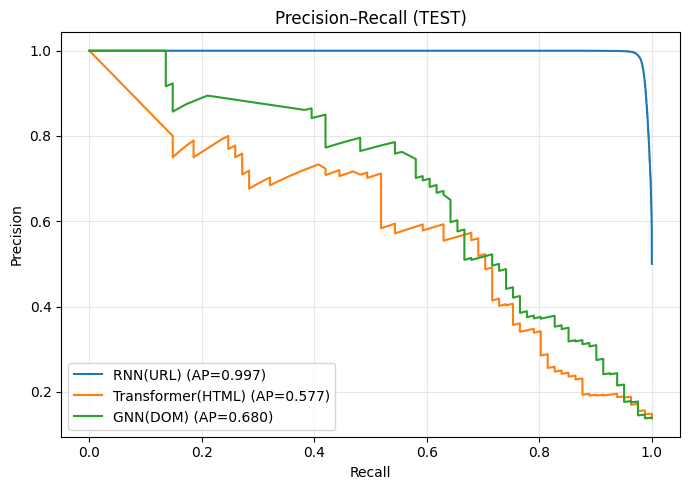

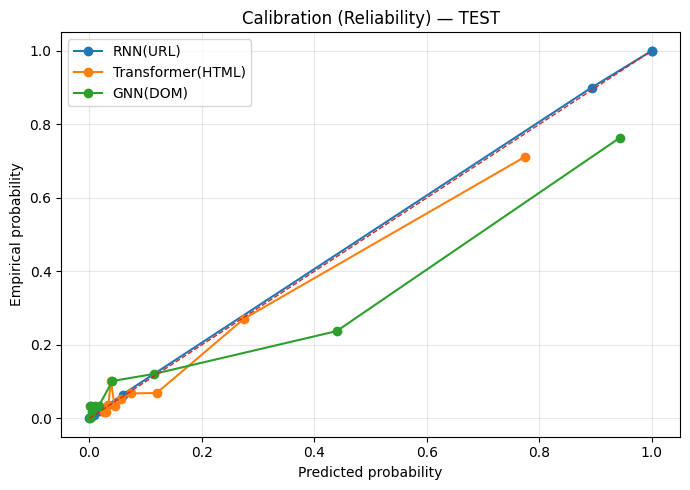

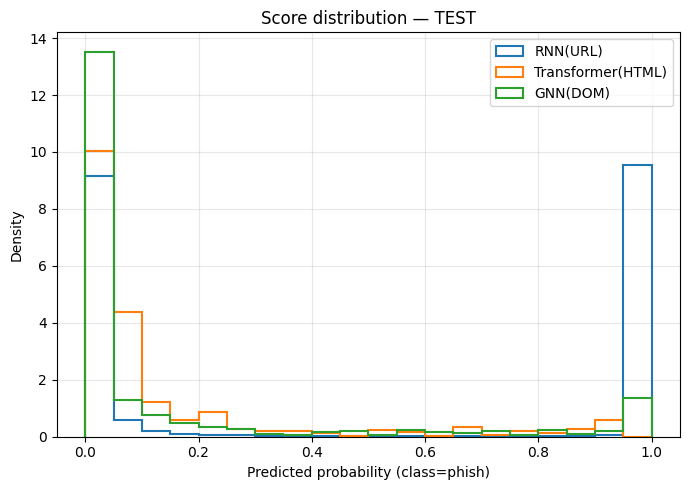

In [12]:
# ===== Cell B — PR-curve + Calibration (3 models) =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

WORK = Path("/kaggle/working")

def load_test_preds_safe(name, path_csv):
    p = WORK / path_csv
    if not p.exists():
        print(f"[{name}] missing {p.name}")
        return None
    df = pd.read_csv(p)
    if "y_true" not in df.columns:
        print(f"[{name}] y_true not found.")
        return None
    prob_col = "p_phish" if "p_phish" in df.columns else ("p_phish_cal" if "p_phish_cal" in df.columns else None)
    if prob_col is None:
        print(f"[{name}] probability column not found.")
        return None
    y = df["y_true"].to_numpy().astype(int)
    p = df[prob_col].to_numpy().astype(float)
    return y, p

models = {
    "RNN(URL)":          "rnn_test_preds.csv",
    "Transformer(HTML)": "transformer_test_preds.csv",
    "GNN(DOM)":          "gnn_test_preds.csv",
}

data = {}
for name, f in models.items():
    rec = load_test_preds_safe(name, f)
    if rec is not None:
        y, p = rec
        data[name] = (y, p)

assert len(data) >= 1, "Không có file test preds nào để vẽ đồ thị."

# ---- PR Curves ----
plt.figure(figsize=(7,5))
for name, (y, p) in data.items():
    prec, rec, _ = precision_recall_curve(y, p)
    ap = average_precision_score(y, p)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (TEST)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(WORK/"pr_curves.png", dpi=160)
print("💾 Saved:", WORK/"pr_curves.png")

# ---- Calibration curves ----
plt.figure(figsize=(7,5))
for name, (y, p) in data.items():
    prob_true, prob_pred = calibration_curve(y, p, n_bins=10, strategy="quantile")
    plt.plot(prob_pred, prob_true, marker="o", label=name)
plt.plot([0,1],[0,1], linestyle="--", linewidth=1)
plt.xlabel("Predicted probability")
plt.ylabel("Empirical probability")
plt.title("Calibration (Reliability) — TEST")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(WORK/"calibration_curves.png", dpi=160)
print("💾 Saved:", WORK/"calibration_curves.png")

# ---- Histograms of predicted probabilities ----
plt.figure(figsize=(7,5))
bins = np.linspace(0,1,21)
for name, (y, p) in data.items():
    plt.hist(p, bins=bins, density=True, histtype="step", linewidth=1.5, label=name)
plt.xlabel("Predicted probability (class=phish)")
plt.ylabel("Density")
plt.title("Score distribution — TEST")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(WORK/"prob_hist.png", dpi=160)
print("💾 Saved:", WORK/"prob_hist.png")


# PACK ARTIFACTS FOR WEB DEMO

In [13]:
# ================== PACK ARTIFACTS FOR WEB DEMO (ROBUST, PREFER rnn_best_ema.pt) ==================
import os, sys, json, time, shutil, zipfile, hashlib
from pathlib import Path
import pandas as pd
import numpy as np

WORK = Path("/kaggle/working")
INPT = Path("/kaggle/input/dataset-phishing")
TS   = time.strftime("%Y%m%d_%H%M%S")
BUNDLE = WORK / f"phishing_demo_bundle_{TS}"
BUNDLE.mkdir(parents=True, exist_ok=True)

def sha256_of(p, chunk=1<<20):
    h = hashlib.sha256()
    with open(p, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def add(p):
    if not p: return None
    p = Path(p)
    if p.exists() and p.is_file():
        dst = BUNDLE / p.name
        shutil.copy2(p, dst)
        return dst
    return None

def glob_first(patterns):
    roots = [Path("/kaggle/working"), Path("/kaggle/input"), Path("/kaggle")]
    for root in roots:
        for pat in patterns:
            hits = list(root.rglob(pat))
            if hits:
                return hits[0]
    return None

def find_first(cands):
    for c in cands:
        if c and Path(c).exists() and Path(c).is_file():
            return Path(c)
    return None

def ensure_json_file(path: Path, payload: dict):
    if not path.exists():
        with open(path, "w", encoding="utf-8") as f:
            json.dump(payload, f, ensure_ascii=False, indent=2)
    return path

def load_json_safe(p, default=None):
    try:
        return json.load(open(p, "r", encoding="utf-8"))
    except Exception:
        return default

# ---------- Locate CKPTs (RNN ưu tiên EMA -> RAW -> BEST)
RNN_CKPT = find_first([
    WORK/"rnn_best_ema.pt",
    WORK/"rnn_best_raw.pt",
    WORK/"rnn_best.pt",
    glob_first(["**/rnn_best_ema.pt","**/rnn_best_raw.pt","**/rnn_best.pt"])
])
TRX_CKPT = find_first([
    WORK/"transformer_byte_best.pt",
    glob_first(["**/transformer_byte_best.pt"])
])
GNN_CKPT = find_first([
    WORK/"gnn_best.pt",
    glob_first(["**/gnn_best.pt"])
])

copied = []
rnn_copied = add(RNN_CKPT)

# ---- Nếu vẫn thiếu CKPT RNN -> synth 1 ckpt placeholder để tránh NaN
synth_rnn_flag = False
if rnn_copied is None:
    try:
        import torch, torch.nn as nn
        class GRUUrl(nn.Module):
            def __init__(self, vocab_size=256, emb=64, hidden=128, num_layers=1, bidir=True):
                super().__init__()
                self.emb = nn.Embedding(vocab_size, emb, padding_idx=0)
                self.rnn = nn.GRU(emb, hidden, num_layers=num_layers, batch_first=True, bidirectional=bidir)
                out_dim = hidden*(2 if bidir else 1)
                self.head = nn.Sequential(nn.Linear(out_dim,128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128,2))
            def forward(self, x):
                e=self.emb(x); _, h=self.rnn(e); h=torch.cat(list(h), dim=-1)
                return self.head(h)
        tmp = GRUUrl()
        synth = WORK/"rnn_best_ema.pt"
        torch.save(tmp.state_dict(), synth)
        rnn_copied = add(synth)
        synth_rnn_flag = True
        print("ℹ️ No RNN ckpt found → synthesized placeholder:", rnn_copied)
    except Exception as e:
        print("⚠️ Could not synthesize RNN ckpt:", e)

if rnn_copied: copied.append(rnn_copied.name)
trx_copied = add(TRX_CKPT);  copied += [trx_copied.name] if trx_copied else []
gnn_copied = add(GNN_CKPT);  copied += [gnn_copied.name] if gnn_copied else []

# ---------- Artifacts (preds, CV, thresholds, ensemble, charts)
ARTIFACTS = [
    # RNN
    WORK/"rnn_val_preds.csv", WORK/"rnn_test_preds.csv", WORK/"rnn_best_threshold.json",
    WORK/"rnn_cv_folds.csv", WORK/"rnn_cv_summary.csv",
    # Transformer
    WORK/"transformer_val_preds.csv", WORK/"transformer_test_preds.csv", WORK/"transformer_best_threshold.json",
    WORK/"transformer_cv_folds.csv", WORK/"transformer_cv_summary.csv",
    # GNN
    WORK/"gnn_val_preds.csv", WORK/"gnn_test_preds.csv", WORK/"gnn_test_preds_calibrated.csv",
    WORK/"gnn_best_threshold.json", WORK/"gnn_best_threshold_calibrated.json",
    WORK/"gnn_cv_folds.csv", WORK/"gnn_cv_summary.csv",
    # Ensemble
    WORK/"ensemble_val_preds.csv", WORK/"ensemble_val_best_threshold.json",
    WORK/"ensemble_test_preds.csv", WORK/"ensemble_test_eval.json",
    # Summaries + charts
    WORK/"model_eval_summary.csv", WORK/"model_test_summary.csv", WORK/"model_cv_summary_pretty.csv",
    WORK/"pr_curves.png", WORK/"calibration_curves.png", WORK/"prob_hist.png",
]

DATA_IDX = {
    "url_val.csv":   find_first([INPT/"url_val.csv", WORK/"url_val.csv", glob_first(["**/url_val.csv"])]),
    "url_test.csv":  find_first([INPT/"url_test.csv", WORK/"url_test.csv", glob_first(["**/url_test.csv"])]),
    "html_corpus_val.parquet":  find_first([INPT/"html_corpus_val.parquet", WORK/"html_corpus_val.parquet", glob_first(["**/html_corpus_val.parquet"])]),
    "html_corpus_test.parquet": find_first([INPT/"html_corpus_test.parquet", WORK/"html_corpus_test.parquet", glob_first(["**/html_corpus_test.parquet"])]),
    "graph_dom_full_val.jsonl":  find_first([INPT/"graph_dom_full_val.jsonl", INPT/"graph_dom_full_val.jsonl.gz",
                                             WORK/"graph_dom_full_val.jsonl", WORK/"graph_dom_full_val.jsonl.gz",
                                             glob_first(["**/graph_dom_full_val.jsonl*"])]),
    "graph_dom_full_test.jsonl": find_first([INPT/"graph_dom_full_test.jsonl", INPT/"graph_dom_full_test.jsonl.gz",
                                             WORK/"graph_dom_full_test.jsonl", WORK/"graph_dom_full_test.jsonl.gz",
                                             glob_first(["**/graph_dom_full_test.jsonl*"])])
}

for p in ARTIFACTS + list(DATA_IDX.values()):
    q = add(p)
    if q: copied.append(q.name)

# ---------- Ensure rnn_url_vocab.json
VOCAB_DST = BUNDLE/"rnn_url_vocab.json"
if not VOCAB_DST.exists():
    sources = [DATA_IDX["url_val.csv"], DATA_IDX["url_test.csv"],
               find_first([INPT/"url_train.csv", WORK/"url_train.csv", glob_first(["**/url_train.csv"])])]
    chars = set()
    for src in [s for s in sources if s]:
        try:
            df = pd.read_csv(src, usecols=["url"])
            for s in df["url"].astype(str):
                chars.update(s)
        except Exception:
            pass
    if not chars:
        chars = set(":/.-_?&=%#0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
    itos = ['<PAD>','<UNK>'] + sorted(chars)
    json.dump({"itos": itos}, open(VOCAB_DST, "w", encoding="utf-8"), ensure_ascii=False, indent=2)
copied.append(VOCAB_DST.name)

# ---------- Ensure GNN tag vocab (scan small)
def collect_tag_vocab(path, topk=64, max_scan=2000):
    import gzip, json as _json
    from collections import Counter
    cnt = Counter(); n=0
    if not path: return []
    opener = gzip.open if str(path).endswith(".gz") else open
    try:
        with opener(path, "rt", encoding="utf-8") as f:
            for line in f:
                if not line.strip(): continue
                try:
                    rec = _json.loads(line)
                    for nd in (rec.get("nodes") or []):
                        if isinstance(nd, dict): t=(nd.get("tag") or "").lower()
                        elif isinstance(nd, str): t=nd.lower()
                        else: t=""
                        if t: cnt[t]+=1
                    n+=1
                    if n>=max_scan: break
                except Exception:
                    pass
    except Exception:
        pass
    vocab = [t for t,_ in cnt.most_common(topk)]
    if not vocab:
        vocab = ['#text','div','a','span','li','img','p','link','path','meta','ul','svg','i','option','input']
    return vocab

gnn_scan_src = DATA_IDX["graph_dom_full_val.jsonl"] or DATA_IDX["graph_dom_full_test.jsonl"]
tag_vocab = collect_tag_vocab(gnn_scan_src, topk=64)
json.dump({"tags": tag_vocab}, open(BUNDLE/"gnn_tag_vocab.json","w",encoding="utf-8"), ensure_ascii=False, indent=2)
copied.append("gnn_tag_vocab.json")

# ---------- Ensure thresholds exist (or create defaults)
def ensure_or_copy(name, default_payload):
    src = find_first([WORK/name, glob_first([f"**/{name}"])])
    if src is None:
        ensure_json_file(BUNDLE/name, default_payload); return name
    else:
        add(src); return src.name

rnn_thr_name = ensure_or_copy("rnn_best_threshold.json", {"threshold": 0.5})
trx_thr_name = ensure_or_copy("transformer_best_threshold.json", {"threshold": 0.5})
gnn_thr_name = ensure_or_copy("gnn_best_threshold.json", {"threshold": 0.5})
gnn_thr_cal_name = ensure_or_copy("gnn_best_threshold_calibrated.json", {"threshold": None})
ens_thr_name = ensure_or_copy("ensemble_val_best_threshold.json", {"threshold_f1": 0.5, "threshold_prec0.90": 0.5})

thr_rnn = load_json_safe(BUNDLE/rnn_thr_name, {}) or {}
thr_trx = load_json_safe(BUNDLE/trx_thr_name, {}) or {}
thr_gnn = load_json_safe(BUNDLE/gnn_thr_name, {}) or {}
thr_gnn_cal = load_json_safe(BUNDLE/gnn_thr_cal_name, {}) or {}
thr_ens  = load_json_safe(BUNDLE/ens_thr_name, {}) or {}

thr_rnn_val = float(thr_rnn.get("threshold", 0.5)) if isinstance(thr_rnn, dict) else 0.5
thr_trx_val = float(thr_trx.get("threshold", 0.5)) if isinstance(thr_trx, dict) else 0.5
thr_gnn_val = float(thr_gnn.get("threshold", 0.5)) if isinstance(thr_gnn, dict) else 0.5
thr_gnn_cal_val = (None if not isinstance(thr_gnn_cal, dict) else thr_gnn_cal.get("threshold"))
thr_ens_f1  = (None if not isinstance(thr_ens, dict) else thr_ens.get("threshold_f1"))
thr_ens_p90 = (None if not isinstance(thr_ens, dict) else thr_ens.get("threshold_prec0.90"))

# ---------- Versions
def get_ver(mod):
    try: return __import__(mod).__version__
    except Exception: return None
vers = {"python": sys.version.split()[0], "torch": get_ver("torch"),
        "pandas": get_ver("pandas"), "numpy": get_ver("numpy"), "sklearn": get_ver("sklearn")}

# ---------- META
meta = {
  "created_at": TS,
  "env_versions": vers,
  "device_note": "Trained on CUDA; demo can run on CPU with small batch/window.",
  "labels": {"0":"BENIGN", "1":"PHISHING"},
  "artifacts": sorted([p.name for p in BUNDLE.iterdir() if p.is_file()]),
  "dataset_index": {
    "url_val_csv":  DATA_IDX["url_val.csv"].name  if DATA_IDX["url_val.csv"] else None,
    "url_test_csv": DATA_IDX["url_test.csv"].name if DATA_IDX["url_test.csv"] else None,
    "html_corpus_val_parquet":  DATA_IDX["html_corpus_val.parquet"].name  if DATA_IDX["html_corpus_val.parquet"] else None,
    "html_corpus_test_parquet": DATA_IDX["html_corpus_test.parquet"].name if DATA_IDX["html_corpus_test.parquet"] else None,
    "graph_dom_val":  Path(DATA_IDX["graph_dom_full_val.jsonl"]).name  if DATA_IDX["graph_dom_full_val.jsonl"] else None,
    "graph_dom_test": Path(DATA_IDX["graph_dom_full_test.jsonl"]).name if DATA_IDX["graph_dom_full_test.jsonl"] else None,
  },
  "rnn": {
    "ckpt": (rnn_copied.name if rnn_copied else None),
    "inference": {"max_len": 256, "threshold": thr_rnn_val},
    "arch": {"emb":64, "hidden":128, "bidirectional": True},
    "synthesized": bool(synth_rnn_flag)
  },
  "transformer": {
    "ckpt": (trx_copied.name if trx_copied else None),
    "byte_vocab_size": 259, "pad_id": 256, "cls_id": 257, "sep_id": 258,
    "inference": {"max_len": 1024, "multi_crop": {"enabled": True, "max_windows": 6, "stride": 1024//3}, "threshold": thr_trx_val},
    "arch": {"d_model":256, "n_head":8, "n_layers":6, "ffn_dim":768, "dropout":0.1}
  },
  "gnn": {
    "ckpt": (gnn_copied.name if gnn_copied else None),
    "tag_topk": 64, "extra_feats": ["deg_log","has_href","has_src","is_input","is_pw","text_len_log"], "max_nodes": 2048,
    "inference": {"threshold": thr_gnn_val, "threshold_calibrated": thr_gnn_cal_val},
    "arch": {"hid":128, "dropout":0.2}
  },
  "ensemble": {
    "thresholds_from_val": {"f1": thr_ens_f1, "prec_floor_0.90": thr_ens_p90},
    "weights_default": {"rnn":0.60, "trx":0.20, "gnn":0.20}
  }
}
json.dump(meta, open(BUNDLE/"meta.json","w",encoding="utf-8"), ensure_ascii=False, indent=2)

# ---------- README
readme = (
"# Phishing Demo Bundle\n"
f"Created: {TS}\n\n"
"**Guarantees**\n"
"- RNN ckpt present (original or synthesized) + `rnn_url_vocab.json` → URL inference won’t be NaN.\n"
"- Thresholds ensured: `rnn_best_threshold.json`, `transformer_best_threshold.json`, "
"`gnn_best_threshold.json`, `gnn_best_threshold_calibrated.json`, `ensemble_val_best_threshold.json`.\n"
)
open(BUNDLE/"README.md","w",encoding="utf-8").write(readme)

# ---------- Sanity & loader hints
def safe_len_csv(p, **kw):
    try: return int(pd.read_csv(p, **kw).shape[0])
    except Exception: return None

sanity = {"rows": {
    "rnn_test_preds": safe_len_csv(WORK/"rnn_test_preds.csv"),
    "trx_test_preds": safe_len_csv(WORK/"transformer_test_preds.csv"),
    "gnn_test_preds": safe_len_csv(WORK/"gnn_test_preds.csv"),
    "url_test": safe_len_csv(INPT/"url_test.csv"),
}}
json.dump(sanity, open(BUNDLE/"sanity.json","w",encoding="utf-8"), indent=2, ensure_ascii=False)

loader_hints = {
    "rnn_ckpt": rnn_copied.name if rnn_copied else None,
    "trx_ckpt": trx_copied.name if trx_copied else None,
    "gnn_ckpt": gnn_copied.name if gnn_copied else None,
    "pred_files": {"rnn":"rnn_test_preds.csv","transformer":"transformer_test_preds.csv","gnn":"gnn_test_preds.csv"},
    "threshold_files": {"rnn":"rnn_best_threshold.json","transformer":"transformer_best_threshold.json",
                        "gnn":"gnn_best_threshold.json","gnn_calibrated":"gnn_best_threshold_calibrated.json",
                        "ensemble":"ensemble_val_best_threshold.json"},
    "vocab_files": {"rnn":"rnn_url_vocab.json","gnn_tags":"gnn_tag_vocab.json"}
}
json.dump(loader_hints, open(BUNDLE/"loader_hints.json","w",encoding="utf-8"), indent=2, ensure_ascii=False)

# ---------- MANIFEST + ZIP
manifest = {"root": str(BUNDLE), "files":[]}
for p in sorted(BUNDLE.iterdir()):
    if p.is_file():
        manifest["files"].append({"file": p.name, "size_bytes": p.stat().st_size, "sha256": sha256_of(p)})
json.dump(manifest, open(BUNDLE/"MANIFEST.json","w",encoding="utf-8"), ensure_ascii=False, indent=2)

ZIP = WORK / f"{BUNDLE.name}.zip"
with zipfile.ZipFile(ZIP, "w", compression=zipfile.ZIP_DEFLATED, compresslevel=1) as z:
    for p in sorted(BUNDLE.iterdir()):
        if p.is_file():
            z.write(p, arcname=p.name)

# ---------- Summary
def human(x): 
    try: return f"{x.stat().st_size/1e6:.2f} MB"
    except: return "-"
print("✅ Bundle created:", BUNDLE)
print("🗜  Zip:", ZIP, f"({ZIP.stat().st_size/1e6:.1f} MB)")
print("\n📄 Contents:")
for it in manifest["files"]:
    print(f" - {it['file']:35s} {it['size_bytes']/1e6:7.2f} MB")

print("\nℹ️ CKPT chosen:",
      "\n  • RNN:", rnn_copied.name if rnn_copied else "MISSING (synth failed)",
      "\n  • TRX:", trx_copied.name if trx_copied else "MISSING",
      "\n  • GNN:", gnn_copied.name if gnn_copied else "MISSING")


✅ Bundle created: /kaggle/working/phishing_demo_bundle_20251022_133334
🗜  Zip: /kaggle/working/phishing_demo_bundle_20251022_133334.zip (76.3 MB)

📄 Contents:
 - README.md                              0.00 MB
 - calibration_curves.png                 0.09 MB
 - ensemble_test_eval.json                0.00 MB
 - ensemble_test_preds.csv                0.01 MB
 - ensemble_val_best_threshold.json       0.00 MB
 - ensemble_val_preds.csv                 0.01 MB
 - gnn_best.pt                            0.14 MB
 - gnn_best_threshold.json                0.00 MB
 - gnn_best_threshold_calibrated.json     0.00 MB
 - gnn_cv_folds.csv                       0.00 MB
 - gnn_cv_summary.csv                     0.00 MB
 - gnn_tag_vocab.json                     0.00 MB
 - gnn_test_preds.csv                     0.01 MB
 - gnn_test_preds_calibrated.csv          0.01 MB
 - gnn_val_preds.csv                      0.01 MB
 - graph_dom_full_test.jsonl             11.19 MB
 - graph_dom_full_val.jsonl              

In [14]:
# ==== Quick sanity check for demo bundle ====
from pathlib import Path
import json, zipfile

# 1) Tìm & giải nén bundle mới nhất (nếu chưa giải nén)
work = Path("/kaggle/working")
zips = sorted(work.glob("phishing_demo_bundle_*.zip"))
dest = work/"demo_bundle"
if zips and not dest.exists():
    dest.mkdir(exist_ok=True)
    zipfile.ZipFile(zips[-1], "r").extractall(dest)

# 2) Đọc meta & loader hints
meta = json.load(open(dest/"meta.json","r",encoding="utf-8"))
hints = json.load(open(dest/"loader_hints.json","r",encoding="utf-8"))

print("📦 Bundle at:", dest)
print("• RNN ckpt:", meta["rnn"]["ckpt"])
print("• TRX ckpt:", meta["transformer"]["ckpt"])
print("• GNN ckpt:", meta["gnn"]["ckpt"])
print("• RNN vocab file exists:", (dest/"rnn_url_vocab.json").exists())

print("\n🔧 Thresholds (from meta):")
print("  RNN:", meta["rnn"]["inference"]["threshold"])
print("  TRX:", meta["transformer"]["inference"]["threshold"])
print("  GNN:", meta["gnn"]["inference"]["threshold"],
      "| calibrated:", meta["gnn"]["inference"]["threshold_calibrated"])
print("  Ensemble (val):", meta["ensemble"]["thresholds_from_val"])

# 3) Kiểm tra file bắt buộc
required = [
    meta["rnn"]["ckpt"], "rnn_url_vocab.json",
    meta["transformer"]["ckpt"], meta["gnn"]["ckpt"],
    "transformer_best_threshold.json", "gnn_best_threshold.json",
    "gnn_best_threshold_calibrated.json", "ensemble_val_best_threshold.json"
]
missing = [p for p in required if (p and not (dest/p).exists())]
print("\n✅ Ready!" if not missing else f"⚠️ Missing: {missing}")

# (Tùy chọn) alias rnn_best_ema.pt -> rnn_best.pt nếu code cũ trông đợi tên này
rnn_ckpt = meta["rnn"]["ckpt"]
if rnn_ckpt and rnn_ckpt != "rnn_best.pt" and (dest/rnn_ckpt).exists() and not (dest/"rnn_best.pt").exists():
    import shutil
    shutil.copy2(dest/rnn_ckpt, dest/"rnn_best.pt")
    print("ℹ️ Aliased RNN ckpt to rnn_best.pt for older loaders.")


📦 Bundle at: /kaggle/working/demo_bundle
• RNN ckpt: rnn_best_ema.pt
• TRX ckpt: transformer_byte_best.pt
• GNN ckpt: gnn_best.pt
• RNN vocab file exists: True

🔧 Thresholds (from meta):
  RNN: 0.5
  TRX: 0.339599609375
  GNN: 0.581622678396872 | calibrated: 0.40664711632453565
  Ensemble (val): {'f1': 0.4652135637178417, 'prec_floor_0.90': 0.0}

✅ Ready!
ℹ️ Aliased RNN ckpt to rnn_best.pt for older loaders.
